In [1]:
import numpy as np|
from neurodsp.sim import sim_combined
from neurodsp.spectral import compute_spectrum, trim_spectrum
from neurodsp.utils.data import create_times
from neurodsp.plts import plot_time_series, plot_power_spectra
from neurodsp.utils.norm import normalize_sig
# Import IRASA
from neurodsp.aperiodic import compute_irasa, fit_irasa
from scipy.linalg import norm
from itertools import product
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from time import time
import fractions
from scipy import signal
from scipy.optimize import curve_fit

# For multiprocessing
import concurrent.futures

# IRASA

IRASA stands for irregularly resampled auto-spectral analysis. It assumes the signal model is an aperiodic component, namely a 1/f component, added with finitely many sinusoids. These sinusoids manifest themselves as discrete spikes in the power spectrum. IRASA computes the aperiodic component appealing by appealing to the self-similar nature of signals whose power spectrum obeys a power law. Unlike FOOOF, IRASA requires access to the TIMES series in the time domain. By resampling the time series at non-integer rates, the spikes in the power spectrum corresponding to the sinusoids will be shifted in frequency by a quantity proportional to the resampling rate. However, self-similarity of the aperiodic component ensures that the power law decay remains the same across resamplings. Sinusoids are then averaged out across the power spectra of the resampled time series.

IRASA does not explicitly consider signals with a knee, nor does it consider signals where there are central frequencies with some variance around them as in the setting of FOOOF. Below are some examples which detail the performance on IRASA in various settings.

#### Notes
- IRASA seems to perform well when there are a few sinusoids added to the aperiodic component where the frequencies of those sinusoids are sufficiently different, e.g. well-spaced in the frequency range.
    - When the frequencies are close to one another, IRASA does not perform as well.
- Lower frequency sinusoids also seem to negatively impact IRASA's estimation.
- IRASA's behavior seems to be stable across different values of $\chi \in (-3, 0)$.
- In the context of a signal with a central frequency and aperiodic noise, IRASA is not robust to the central frequency's relative height or the bandwidth. 
- Interestingly, for knee signals without an aperiodic component, IRASA's estimate for the aperiodic PSD does feature a knee but it's often the wrong shape. The error in estimating both exponents of the knee is on average between 0.5 and 0.8.
    - For the Lorenztian given by 
    $$ \frac{1}{\omega^{\chi_1}(\omega^{\chi_2} + k)},$$
    IRASA performs the worst when $\chi_1 > \chi_2$ and $\chi_2$ is near zero. In this context, the PSD is visually similar to a powerlaw and does not feature a knee.

In [40]:
#########################################
#
#   Macros
#
#########################################

# Parameter ranges
FS_RANGE = np.arange(150, 1060, 100, dtype='int')
F_RANGE = (1, 50)
FREQS = np.round(np.linspace(*F_RANGE, num=25))
CHIS = -1*np.arange(0, 3, 0.25)   # Use negative values per NeuroDSP convention.


# Static constants
N_SECONDS = 10
FS = 10**3
TIMES = create_times(N_SECONDS, FS)
NUM_TRIALS = 10


#########################################
#
#   Fitting Helper Functions
#
#########################################

def log_space_freqs(freqs, n_points):
    """Given an array of frequency values, returns a subset of those frequency values which are approximately
    equispaced logarithmically."""
    
    # Grab the lowest and highest frequencies to form a logarithmic grid of frequencies, not necessarily
    # corresponding to frequencies in the array freqs
    f_start, f_end = freqs[0], freqs[-1]
    log_grid = np.logspace(np.log10(f_start), np.log10(f_end), n_points)
    
    # For every element in log_grid, find the closest element in freqs
    log_freq_indices = np.array([np.argmin(np.abs(log_freq - freqs)) for log_freq in log_grid]).astype('int')
    log_freqs = freqs[log_freq_indices]
    
    # Throw out any duplicates
    log_freqs = np.unique(log_freqs)
    
    return log_freqs

def fit_func(freqs, intercept, slope):
    """A fit function to use for fitting IRASA separated 1/f power spectra components."""

    return slope * freqs + intercept

def knee_func(freqs, offset, chi1, chi2, knee):
    """
    Logarithm base 10 of the function
    
    offset * 1/(freqs**chi1 * (freqs**chi2 + knee))
    
    used to fit a knee model.
    """
    return np.log10(offset) - chi1*np.log10(freqs) - np.log10(freqs**chi2 + knee)

def fit_irasa_logspace(freqs, psd_aperiodic):
    """Fit the IRASA derived aperiodic component of the spectrum. The fitting uses logarithmically
    spaced frequencies. This is basically copied from NeuroDSP's implementation with only a minor modification before
    the spectral fitting.

    Parameters
    ----------
    freqs : 1d array
        Frequency vector, in linear space.
    psd_aperidic : 1d array
        Power values, in linear space.

    Returns
    -------
    intercept : float
        Fit intercept value.
    slope : float
        Fit slope value.

    Notes
    -----
    This fits a linear function of the form `y = ax + b` to the log-log aperiodic power spectrum.
    """
    
    # Grab log spaced frequencies. Subsample by a factor of 2.
    resampled_freqs = log_space_freqs(freqs, freqs.shape[0]//2)
    
    # Grab the corresponding indices to resample the psd.
    resampled_idxs = np.array([np.argmin(np.abs(resampled_freq - freqs)) for resampled_freq in resampled_freqs])
    resampled_psd = psd_aperiodic[resampled_idxs]
    
    popt, _ = curve_fit(fit_func, np.log10(resampled_freqs), np.log10(resampled_psd))
    intercept, slope = popt

    return intercept, slope

def fit_irasa_knee(freqs, psd_aperiodic):
    
    # Force non-negative parameters.
    lower_bounds = np.array([0, 0, 0, 0])
    upper_bounds = np.array([10, 5, 5, np.inf])
    
    # Dont feed in logarithmic frequencies.
    popt, _ = curve_fit(knee_func, freqs, np.log10(psd_aperiodic), bounds=(lower_bounds, upper_bounds))
    offset, chi1, chi2, knee = popt
    
    return offset, chi1, chi2, knee

#########################################
#
#   Simulation Functions
#
#########################################

def sim_central_freq(n_seconds, fs, chi, central_freq, bw, ht):
    """
    Returns a time series whose full power spectrum consists of a power law with exponent chi
    and a gaussian peak at central_freq with standard deviation bw and relative height ht.
    

    Parameters
    -----------
    n_seconds: float
        Number of seconds elapsed in the time series.
    fs: float
        Sampling rate.
    chi: float
        Power law exponent.
    central_freq: float
        Central frequency for the gaussian peak in Hz.
    bw: float
        Bandwidth, or standard deviation, of gaussian peak in Hz.
    ht: float
        Relative height in log_10(Hz) over the aperiodic component of the gaussian peak at central_freq.

    Returns
    -------
    sig: 1d array
        Time series with desired power spectrum.

    Examples
    --------
    Simulate aperiodic noise with exponent -2 superimposed over an oscillatory component with
    central frequency 20.

    >>> sig = sim_gauss_peak(n_seconds=50, fs=500, chi=-2, central_freq=20, bw=5, ht=7)
    """

    times = create_times(n_seconds, fs)

    # Construct the aperiodic component and compute its Fourier transform. Only use the
    # first half of the frequencies from the Fourier transform since the signal is real.
    sig_components = {'sim_powerlaw': {'exponent': chi}}
    sig_ap = sim_combined(n_seconds, fs, sig_components)
    sig_len = sig_ap.shape[0]

    sig_ap_hat = np.fft.fft(sig_ap)[0:(sig_len//2+1)]

    # Create the range of frequencies that appear in the power spectrum since these
    # will be the frequencies in the cosines we sum below
    freqs = np.linspace(0, fs/2, num=sig_len//2 + 1, endpoint=True)

    # Construct the array of relative heights above the aperiodic power spectrum
    rel_heights = np.array([ ht * np.exp(-(f - central_freq)**2/(2*bw**2)) for f in freqs])

    # Build an array of the sum of squares of the cosines as they appear in the calculation of the
    # amplitudes
    cosine_norms = np.array([
                          norm(
                            np.cos(2*np.pi*f*times), 2
                          )**2 for f in freqs
                        ])

    # Build an array of the amplitude coefficients
    cosine_coeffs = np.array([
                    (-np.real(sig_ap_hat[ell]) + np.sqrt(np.real(sig_ap_hat[ell])**2 + (10**rel_heights[ell] - 1)*np.abs(sig_ap_hat[ell])**2))/cosine_norms[ell]
                    for ell in range(cosine_norms.shape[0])]
                )

    # Add cosines with the respective coefficients and with a random phase shift for each one
    sig_periodic = np.sum(
                    np.array(
                        [cosine_coeffs[ell]*np.cos(2*np.pi*freqs[ell]*times + 2*np.pi*np.random.rand()) for ell in range(cosine_norms.shape[0])]
                    ),
                    axis=0
                    )

    sig = sig_ap + sig_periodic

    return normalize_sig(sig)

def sim_knee(n_seconds, fs, chi1, chi2, k):
    """
    Returns a time series whose power spectrum follows the Lorentzian equation

    P(f) = 1 / (f**chi1 * (f**chi2 + k))

    using a sum of sinusoids.

    Parameters
    -----------
    n_seconds: float
        Number of seconds elapsed in the time series.
    fs: float
        Sampling rate.
    chi1: float
        Power law exponent before the knee.
    chi2: float
        Power law exponent added to chi1 after the knee.
    k: float
        Knee parameter.

    Returns
    -------
    sig: 1d array
        Time series with desired power spectrum.

    Notes
    -----
    The slope of the log power spectrum before the knee is -chi1 whereas after the knee it is -(chi1 + chi2).

    Examples
    --------
    Simulate a time series with (chi1, chi2, k) = (1, 2, 100)

    >> sim_knee(n_seconds=10, fs=10**3, chi1=1, chi2=2, k=100)
    """

    times = create_times(n_seconds, fs)
    sig_len = fs*n_seconds

    # Create the range of frequencies that appear in the power spectrum since these
    # will be the frequencies in the cosines we sum below
    freqs = np.linspace(0, fs/2, num=sig_len//2 + 1, endpoint=True)

    # Drop the DC component
    freqs = freqs[1:]

    # Map the frequencies under the (square root) Lorentzian. This will give us the amplitude coefficients
    # for the sinusoids.
    cosine_coeffs = np.array([np.sqrt(1/(f**chi1*(f**chi2 + k))) for f in freqs])

    # Add sinusoids with a random phase shift
    sig = np.sum(
                np.array(
                    [cosine_coeffs[ell]*np.cos(2*np.pi*f*times + 2*np.pi*np.random.rand()) for ell, f in enumerate(freqs)]
                ),
                axis=0
                )

    return normalize_sig(sig)

#########################################
#
#  Experiment functions
#
#########################################

def multiple_sines_trial(n_seconds, fs, chi, sine_freqs, f_range=None, log_space_irasa=False):
    """
    Generates a time series with power law exponent chi and sinusoids with frequencies sine_freqs
    and returns the estimated power law exponent using IRASA.
    """
    
    times = create_times(n_seconds, fs)
    
    # Collect IRASA settings
    irasa_params = {'fs' : fs, 'f_range' : f_range}
    sim_components = {'sim_powerlaw': {'exponent' : chi},
                  'sim_oscillation': [{'freq' : sine_freq} for sine_freq in sine_freqs]}
    sig = sim_combined(n_seconds, fs, sim_components)
    

    freqs_irasa, psd_ap, psd_pe = compute_irasa(sig, **irasa_params)
    fit_off, fit_exp = fit_irasa(freqs_irasa, psd_ap) if not log_space_irasa else fit_irasa_logspace(freqs_irasa, psd_ap)
    
    return fit_exp

def central_frequency_trial(n_seconds, fs, f_range, chi, central_freq, ht, bw, seed=None):
    """
    Generates a time series with power law exponent chi and sinusoids with frequencies sine_freqs
    and returns the estimated power law exponent using IRASA.
    """
    
    times = create_times(n_seconds, fs)
    
    # Collect IRASA settings
    irasa_params = {'fs' : fs, 'f_range' : f_range}
    if seed is not None:
        np.random.seed(seed)
    sig = sim_central_freq(n_seconds, fs, chi, central_freq, bw, ht)
    
    freqs_irasa, psd_ap, psd_pe = compute_irasa(sig, **irasa_params)
    fit_off, fit_exp = fit_irasa(freqs_irasa, psd_ap)
    
    return fit_exp

def knee_trial(n_seconds, fs, f_range=None, **sim_knee_kwargs):
    """
    Generates a time series with power law exponent chi and sinusoids with frequencies sine_freqs
    and returns the estimated power law exponent using IRASA.
    """
    
    times = create_times(n_seconds, fs)
    
    # Collect IRASA settings
    irasa_params = {'fs' : fs, 'f_range' : f_range}
    sig = sim_knee(n_seconds, fs, **sim_knee_kwargs)
    

    freqs_irasa, psd_ap, psd_pe = compute_irasa(sig, **irasa_params)
    fit_offset, fit_chi1, fit_chi2, fit_knee = fit_irasa_knee(freqs_irasa, psd_ap)
    
    return fit_chi1, fit_chi2, fit_knee

## No Oscillations

To start, we compare how well IRASA does at estimating the power law exponent when there are no oscillations. We compare this to the modified IRASA where we downsample the power spectrum at logarithmically spaced frequencies and look at how the error behaves as a function of the sampling rate. We choose the minimal sampling rate to be at least 3 TIMES that of the maximal frequency in the frequency range, since IRASA seems to perform very poorly when the maximum of the frequency range is close to the Nyquist frequency. Further, we look at the average error and the variance of the error across many trials since the results of each trial are a function of the draw of spectrally rotated noise.

In [3]:
# Configure the dataframes
parameter_grid = list(product(CHIS, FS_RANGE, range(NUM_TRIALS)))
num_rows = len(parameter_grid)
columns = ['chi', 'fs', 'trial', 'chi_err']
df = pd.DataFrame(data=np.zeros((num_rows, len(columns))), columns=columns)
df[columns[:-1]] = parameter_grid
df_log = pd.DataFrame(data=np.zeros((num_rows, len(columns))), columns=columns)
df_log[columns[:-1]] = parameter_grid

In [4]:
# Set random seed
np.random.seed(0)

# Run the experiment
tic = time()
for fs, chi, trial_idx in product(FS_RANGE, CHIS, range(NUM_TRIALS)):
    irasa_params = {'fs' : fs, 'f_range' : F_RANGE}
    sim_components = {'sim_powerlaw': {'exponent' : chi}}
    sig = sim_combined(N_SECONDS, fs, sim_components)

    # Compute aperiodic component using IRASA
    freqs_irasa, psd_ap, psd_pe = compute_irasa(sig, **irasa_params)

    # Fit using all frequency data and using subsampled log-spaced frequencies
    fit_off, fit_exp = fit_irasa(freqs_irasa, psd_ap)
    fit_off_log, fit_exp_log = fit_irasa_logspace(freqs_irasa, psd_ap)
    
    loc_mask = (df['chi'] == chi) & (df['fs'] == fs) & (df['trial'] == trial_idx)
    df.loc[loc_mask, 'chi_err'] = fit_exp - chi
    df_log.loc[loc_mask, 'chi_err'] = fit_exp_log - chi
toc = time()
print(f"{toc-tic:.2f} seconds")

36.73 seconds


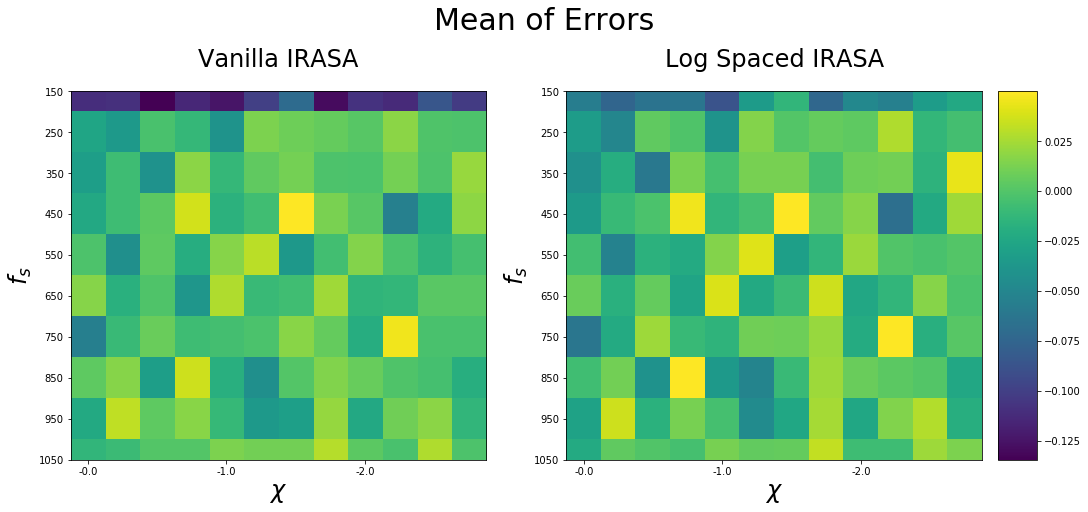

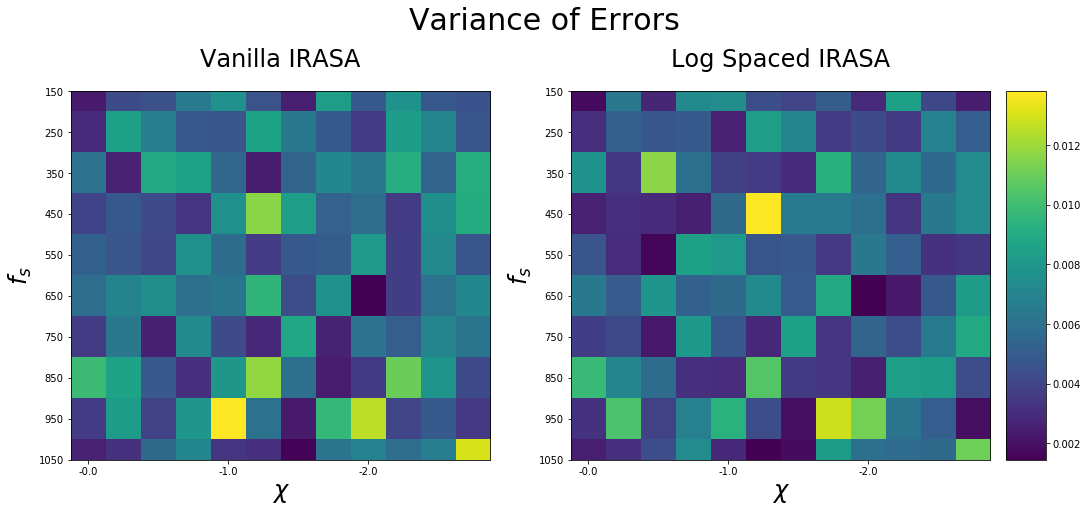

In [21]:
# Make a dataframe of average errors and keep track of the variances as well
mean_var_df = df.groupby(by=['chi', 'fs']).agg({'chi_err': ['mean', 'std']})
# Get rid of the top level of column label to make pivoting easier
mean_var_df.columns = mean_var_df.columns.droplevel()
# Finally, flatten the index
mean_var_df = pd.DataFrame(mean_var_df.to_records())

mean_var_df_log = df_log.groupby(by=['chi', 'fs']).agg({'chi_err': ['mean', 'std']})
mean_var_df_log.columns = mean_var_df_log.columns.droplevel()
mean_var_df_log = pd.DataFrame(mean_var_df_log.to_records())

# Pivot to get a matrix of mean errors and variances
mean_errs_df = mean_var_df.set_index(['chi', 'fs'])['mean'].unstack(0)
vars_df = mean_var_df.set_index(['chi', 'fs'])['std'].unstack(0)**2

mean_errs_df_log = mean_var_df_log.set_index(['chi', 'fs'])['mean'].unstack(0)
vars_df_log = mean_var_df_log.set_index(['chi', 'fs'])['std'].unstack(0)**2

##################################
#   
#  Vanilla IRASA Heat Maps
#
##################################

fig, axes = plt.subplots(1,2, figsize = (15,7), constrained_layout=True)

fig.suptitle(r"Mean of $\chi$ Errors", fontsize=30)

# Grab the dynamic range of both mean errors
vmin = min(mean_errs_df.min().min(), mean_errs_df_log.min().min())
vmax = min(mean_errs_df.max().max(), mean_errs_df_log.max().max())

# Plot mean errors for both IRASAs
cax_mean = axes[0].matshow(mean_errs_df, aspect='auto', vmin=vmin, vmax=vmax)
axes[0].set_xlabel(r"$\chi$", fontsize=24)
axes[0].set_ylabel(r"$f_s$", fontsize=24)
axes[0].set_title("Vanilla IRASA", fontsize=24)
axes[0].tick_params(which='major', labelsize=10, labelbottom = True, bottom=True, top = False, labeltop=False)

# Plot mean errors for vanilla IRASA
cax_mean2 = axes[1].matshow(mean_errs_df_log, aspect='auto', vmin=vmin, vmax=vmax)
axes[1].set_xlabel(r"$\chi$", fontsize=24)
axes[1].set_ylabel(r"$f_s$", fontsize=24)
axes[1].set_title("Log Spaced IRASA", fontsize=24)
axes[1].tick_params(which='major', labelsize=10, labelbottom = True, bottom=True, top = False, labeltop=False)

fig.colorbar(cax_mean2)

# Set tick marks and tick labels
plt.setp(axes, xticks=[idx for idx in range(0, CHIS.shape[0], 4)],
        xticklabels=[CHIS[idx] for idx in range(0, CHIS.shape[0], 4)],
        yticks=[idx for idx in range(0, FS_RANGE.shape[0])],
        yticklabels=[FS_RANGE[idx] for idx in range(0, FS_RANGE.shape[0])]);

##################################
#   
#  Log spaced IRASA Heat Maps
#
##################################


fig, axes = plt.subplots(1,2, figsize = (15,7), constrained_layout=True)

fig.suptitle("Variance of $\chi$ Errors", fontsize=30)
# Grab the dynamic range of both mean errors
vmin = min(vars_df.min().min(), vars_df_log.min().min())
vmax = min(vars_df.max().max(), vars_df_log.max().max())

#Plot variances for vanilla IRASA
cax_var = axes[0].matshow(vars_df, aspect='auto')
axes[0].set_xlabel(r"$\chi$", fontsize=24)
axes[0].set_ylabel(r"$f_s$", fontsize=24)
axes[0].set_title("Vanilla IRASA", fontsize=24)
axes[0].tick_params(which='major', labelsize=10, labelbottom = True, bottom=True, top = False, labeltop=False)

#Plot variances for vanilla IRASA
cax_var2 = axes[1].matshow(vars_df_log, aspect='auto')
axes[1].set_xlabel(r"$\chi$", fontsize=24)
axes[1].set_ylabel(r"$f_s$", fontsize=24)
axes[1].set_title("Log Spaced IRASA", fontsize=24)
axes[1].tick_params(which='major', labelsize=10, labelbottom = True, bottom=True, top = False, labeltop=False)

fig.colorbar(cax_var2)

# Set tick marks and tick labels
plt.setp(axes, xticks=[idx for idx in range(0, CHIS.shape[0], 4)],
        xticklabels=[CHIS[idx] for idx in range(0, CHIS.shape[0], 4)],
        yticks=[idx for idx in range(0, FS_RANGE.shape[0])],
        yticklabels=[FS_RANGE[idx] for idx in range(0, FS_RANGE.shape[0])]);

## Aperiodic + 1 Sinusoid

Next, we see how the two versions of IRASA perform when we add one sinusoid to the aperiodic component. Instead of looking at the error as a function of $\chi$ and $f_s$, we will now look at it as a function of $\chi$ and the frequency of the oscillation. As before, we look at the average error and the variance of the error across multiple trials because of the randomness in generating the aperiodic component.

In [5]:
# Configure the dataframes
parameter_grid = list(product(CHIS, FREQS, range(NUM_TRIALS)))
num_rows = len(parameter_grid)
columns = ['chi', 'freq', 'trial', 'chi_err']
df = pd.DataFrame(data=np.zeros((num_rows, len(columns))), columns=columns)
df[columns[:-1]] = parameter_grid
df_log = pd.DataFrame(data=np.zeros((num_rows, len(columns))), columns=columns)
df_log[columns[:-1]] = parameter_grid

In [6]:
# Set random seed
np.random.seed(0)

# Run the experiment
tic = time()
for chi, freq, trial_idx in product(CHIS, FREQS, range(NUM_TRIALS)):
    irasa_exp = multiple_sines_trial(N_SECONDS, FS, chi, [freq], F_RANGE)
    irasa_exp_logspace = multiple_sines_trial(N_SECONDS, FS, chi, [freq], F_RANGE, log_space_irasa=True)
    
    loc_mask = (df['chi'] == chi) & (df['freq'] == freq) & (df['trial'] == trial_idx)
    df.loc[loc_mask, 'chi_err'] = irasa_exp - chi
    df_log.loc[loc_mask, 'chi_err'] = irasa_exp_logspace - chi
toc = time()
print(f"{toc-tic:.2f} seconds")

213.32 seconds


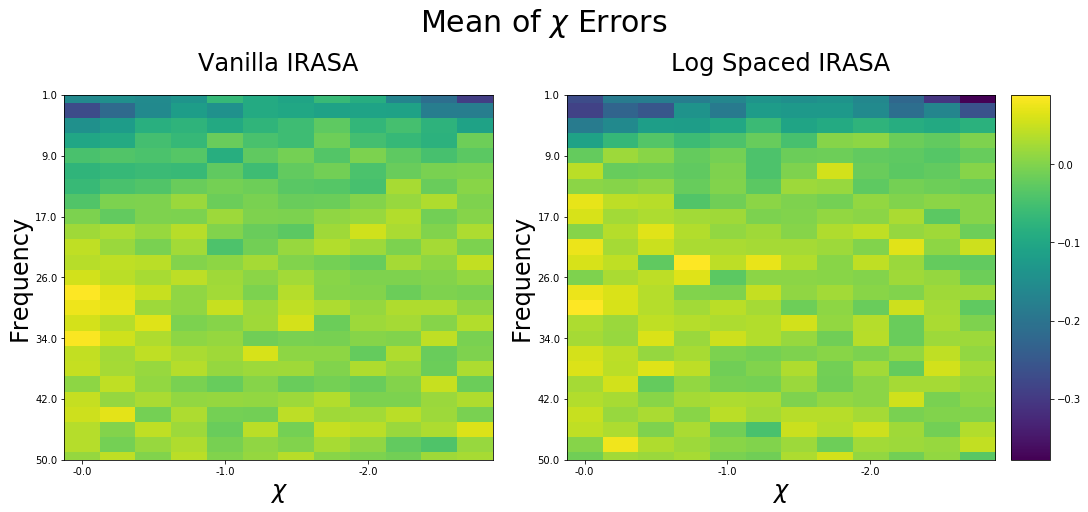

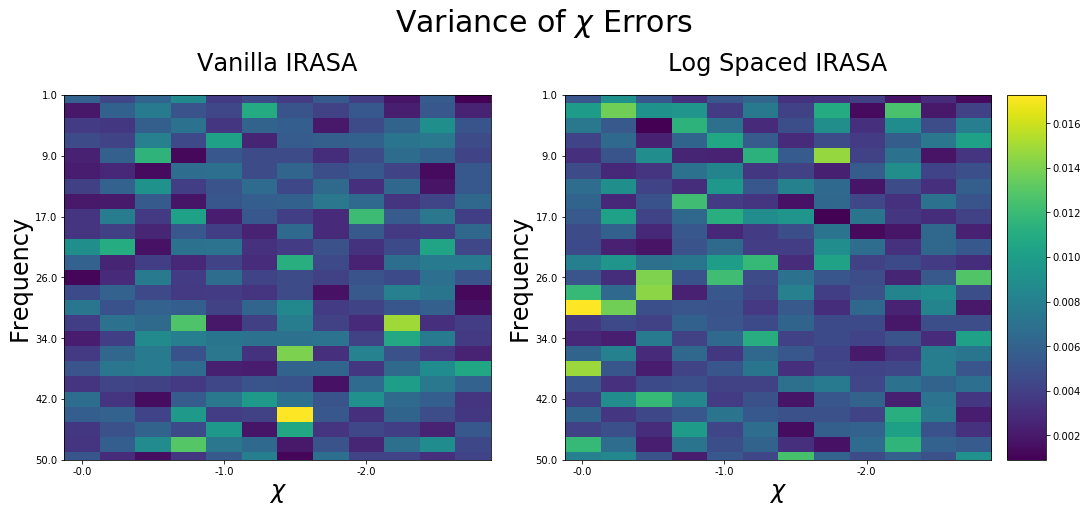

In [11]:
# Make a dataframe of average errors and keep track of the variances as well
mean_var_df = df.groupby(by=['chi', 'freq']).agg({'chi_err': ['mean', 'std']})
# Get rid of the top level of column label to make pivoting easier
mean_var_df.columns = mean_var_df.columns.droplevel()
# Finally, flatten the index
mean_var_df = pd.DataFrame(mean_var_df.to_records())

mean_var_df_log = df_log.groupby(by=['chi', 'freq']).agg({'chi_err': ['mean', 'std']})
mean_var_df_log.columns = mean_var_df_log.columns.droplevel()
mean_var_df_log = pd.DataFrame(mean_var_df_log.to_records())

# Pivot to get a matrix of mean errors and variances
mean_errs_df = mean_var_df.set_index(['chi', 'freq'])['mean'].unstack(0)
vars_df = mean_var_df.set_index(['chi', 'freq'])['std'].unstack(0)**2

mean_errs_df_log = mean_var_df_log.set_index(['chi', 'freq'])['mean'].unstack(0)
vars_df_log = mean_var_df_log.set_index(['chi', 'freq'])['std'].unstack(0)**2

##################################
#   
#  Vanilla IRASA Heat Maps
#
##################################

fig, axes = plt.subplots(1,2, figsize = (15,7), constrained_layout=True)

fig.suptitle("Mean of $\chi$ Errors", fontsize=30)

# Grab the dynamic range of both mean errors
vmin = min(mean_errs_df.min().min(), mean_errs_df_log.min().min())
vmax = min(mean_errs_df.max().max(), mean_errs_df_log.max().max())

# Plot mean errors for both IRASAs
cax_mean = axes[0].matshow(mean_errs_df, aspect='auto', vmin=vmin, vmax=vmax)
axes[0].set_xlabel(r"$\chi$", fontsize=24)
axes[0].set_ylabel("Frequency", fontsize=24)
axes[0].set_title("Vanilla IRASA", fontsize=24)
axes[0].tick_params(which='major', labelsize=10, labelbottom = True, bottom=True, top = False, labeltop=False)

# Plot mean errors for vanilla IRASA
cax_mean2 = axes[1].matshow(mean_errs_df_log, aspect='auto', vmin=vmin, vmax=vmax)
axes[1].set_xlabel(r"$\chi$", fontsize=24)
axes[1].set_ylabel("Frequency", fontsize=24)
axes[1].set_title("Log Spaced IRASA", fontsize=24)
axes[1].tick_params(which='major', labelsize=10, labelbottom = True, bottom=True, top = False, labeltop=False)

fig.colorbar(cax_mean2)

# Set tick marks and tick labels
plt.setp(axes, xticks=[idx for idx in range(0, CHIS.shape[0], 4)],
        xticklabels=[CHIS[idx] for idx in range(0, CHIS.shape[0], 4)],
        yticks=[idx for idx in range(0, FREQS.shape[0], 4)],
        yticklabels=[FREQS[idx] for idx in range(0, FREQS.shape[0], 4)]);

##################################
#   
#  Log spaced IRASA Heat Maps
#
##################################


fig, axes = plt.subplots(1,2, figsize = (15,7), constrained_layout=True)

fig.suptitle("Variance of $\chi$ Errors", fontsize=30)
# Grab the dynamic range of both mean errors
vmin = min(vars_df.min().min(), vars_df_log.min().min())
vmax = min(vars_df.max().max(), vars_df_log.max().max())

#Plot variances for vanilla IRASA
cax_var = axes[0].matshow(vars_df, aspect='auto')
axes[0].set_xlabel(r"$\chi$", fontsize=24)
axes[0].set_ylabel("Frequency", fontsize=24)
axes[0].set_title("Vanilla IRASA", fontsize=24)
axes[0].tick_params(which='major', labelsize=10, labelbottom = True, bottom=True, top = False, labeltop=False)

#Plot variances for vanilla IRASA
cax_var2 = axes[1].matshow(vars_df_log, aspect='auto')
axes[1].set_xlabel(r"$\chi$", fontsize=24)
axes[1].set_ylabel("Frequency", fontsize=24)
axes[1].set_title("Log Spaced IRASA", fontsize=24)
axes[1].tick_params(which='major', labelsize=10, labelbottom = True, bottom=True, top = False, labeltop=False)

fig.colorbar(cax_var2)

# Set tick marks and tick labels
plt.setp(axes, xticks=[idx for idx in range(0, CHIS.shape[0], 4)],
        xticklabels=[CHIS[idx] for idx in range(0, CHIS.shape[0], 4)],
        yticks=[idx for idx in range(0, FREQS.shape[0], 4)],
        yticklabels=[FREQS[idx] for idx in range(0, FREQS.shape[0], 4)]);

## Aperiodic + 4 Well-Spaced Sinusoids (Not sure about this experiment anymore)

IRASA does well with more than one simple oscillatory component provided the frequencies of the sinusoids are sufficiently far apart.

In [ ]:
# Configure the dataframes
parameter_grid = list(product(CHIS, FREQS, range(NUM_TRIALS)))
num_rows = len(parameter_grid)
columns = ['chi', 'freq', 'trial', 'chi_err']
df = pd.DataFrame(data=np.zeros((num_rows, len(columns))), columns=columns)
df[columns[:-1]] = parameter_grid
df_log = pd.DataFrame(data=np.zeros((num_rows, len(columns))), columns=columns)
df_log[columns[:-1]] = parameter_grid

In [7]:
df = pd.DataFrame(data=np.zeros((len(FREQS), CHIS.shape[0])), index=FREQS, columns=CHIS)
df_log = pd.DataFrame(data=np.zeros((len(FREQS), CHIS.shape[0])), index=FREQS, columns=CHIS)
tic = time()
for chi, freq, trial_idx in product(CHIS, FREQS, range(NUM_TRIALS)):
    # Here, take 4 equispaced frequencies in log space between freq and the maximum frequency in F_RANGE.
    sine_freqs = log_space_freqs(np.arange(freq, F_RANGE[1]), 4)
    # Estimate chi
    irasa_exp = multiple_sines_trial(N_SECONDS, FS, chi, sine_freqs, F_RANGE)
    irasa_exp_logspace = multiple_sines_trial(N_SECONDS, FS, chi, sine_freqs, F_RANGE, log_space_irasa=True)
    df.loc[freq][chi] += np.abs(chi - irasa_exp)
    df_log.loc[freq][chi] += np.abs(chi - irasa_exp_logspace)
    
toc = time()
print(f"{toc-tic:.2f} seconds")
df /= NUM_TRIALS

483.50 seconds


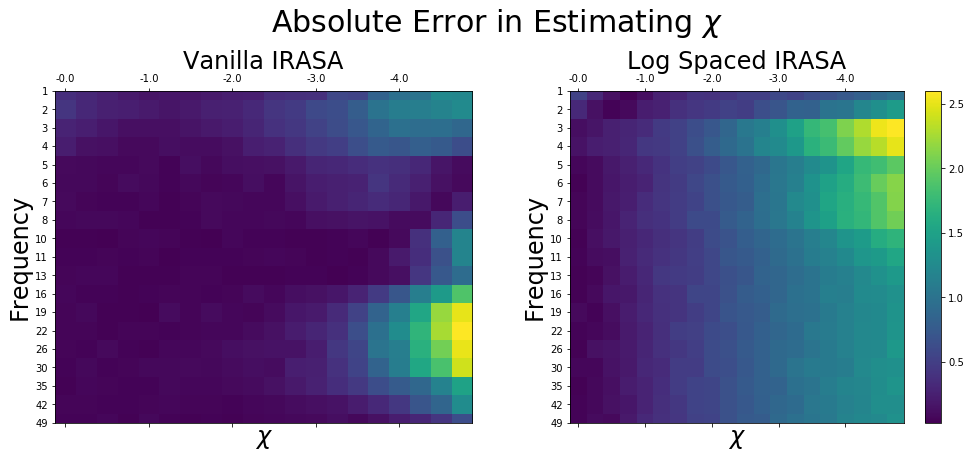

In [8]:
# Matrix plot
fig, axes = plt.subplots(1,2, figsize = (15,7))
cax = axes[0].matshow(df, aspect='auto')
cax2 = axes[1].matshow(df_log, aspect='auto')
axes[0].set_xlabel(r"$\chi$", fontsize=24)
axes[0].set_ylabel("Frequency", fontsize=24)
axes[1].set_xlabel(r"$\chi$", fontsize=24)
axes[1].set_ylabel("Frequency", fontsize=24)
plt.setp(axes, xticks=[idx for idx in range(0, CHIS.shape[0], 4)],
        xticklabels=[CHIS[idx] for idx in range(0, CHIS.shape[0], 4)],
        yticks=[idx for idx in range(0, len(FREQS))],
        yticklabels=[FREQS[idx] for idx in range(0, len(FREQS))])
fig.suptitle(r"Absolute Error in Estimating $\chi$", fontsize=30)
axes[0].set_title("Vanilla IRASA", fontsize=24)
axes[1].set_title("Log Spaced IRASA", fontsize=24)
fig.tight_layout(pad=5.0)
fig.colorbar(cax)

## Aperiodic + Cluster of Sinusoids (seems redundant with central frequency)

However, IRASA does have difficulties when there are multiple sinusoids whose frequencies are close to one another. Below, we superimpose an aperiodic component with a sum of sinusoids whose frequencies span a length of 0.5 in logarithmic spacing of frequencies.

In [8]:
df = pd.DataFrame(data=np.zeros((len(FREQS), CHIS.shape[0])), index=FREQS, columns=CHIS)
df_log = pd.DataFrame(data=np.zeros((len(FREQS), CHIS.shape[0])), index=FREQS, columns=CHIS)
bw = 0.5
tic = time()
for chi, freq, trial_idx in product(CHIS, FREQS, range(NUM_TRIALS)):
    # Sum sinusoids of frequencies whose bandwidth is bw in log space of frequencies.
    f_end = round(10**(bw + np.log10(freq)))
    sine_freqs = [freq for freq in np.arange(freq, f_end, 1./N_SECONDS)]
    irasa_exp = multiple_sines_trial(N_SECONDS, FS, chi, sine_freqs, F_RANGE)
    irasa_exp_logspace = multiple_sines_trial(N_SECONDS, FS, chi, sine_freqs, F_RANGE, log_space_irasa=True)
    df.loc[freq][chi] += np.abs(chi - irasa_exp)
    df_log.loc[freq][chi] += np.abs(chi - irasa_exp_logspace)
toc = time()
print(f"{toc-tic:.2f} seconds")
df /= NUM_TRIALS

1205.41 seconds


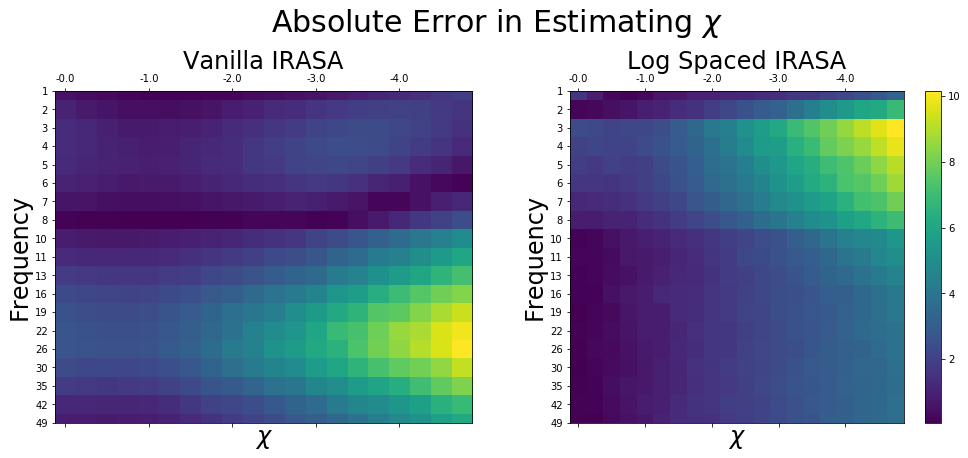

In [9]:
# Matrix plot
fig, axes = plt.subplots(1,2, figsize = (15,7))
cax = axes[0].matshow(df, aspect='auto')
cax2 = axes[1].matshow(df_log, aspect='auto')
axes[0].set_xlabel(r"$\chi$", fontsize=24)
axes[0].set_ylabel("Frequency", fontsize=24)
axes[1].set_xlabel(r"$\chi$", fontsize=24)
axes[1].set_ylabel("Frequency", fontsize=24)
plt.setp(axes, xticks=[idx for idx in range(0, CHIS.shape[0], 4)],
        xticklabels=[CHIS[idx] for idx in range(0, CHIS.shape[0], 4)],
        yticks=[idx for idx in range(0, len(FREQS))],
        yticklabels=[FREQS[idx] for idx in range(0, len(FREQS))])
fig.suptitle(r"Absolute Error in Estimating $\chi$", fontsize=30)
axes[0].set_title("Vanilla IRASA", fontsize=24)
axes[1].set_title("Log Spaced IRASA", fontsize=24)
fig.tight_layout(pad=5.0)
fig.colorbar(cax)

## Aperiodic with Central Frequency

Now we'll test how IRASA performs on signals with an oscillatory and aperiodic component as in the context of FOOOF where there is a central frequency with a pre-defined bandwidth and relative height above the aperiodic component. Here, we'll look at the error as a function of chi, the central_frequency, and the bandwidth. This experiment takes a very long time to run because there are so many parameters to run experiments over. To look at the results of one instance of this experiment, you can run the cell that loads the dataframe from a csv file.

In [5]:
# Set constants for this particular experiment
HEIGHTS = np.linspace(0, 4, num=9) ## in 10**Hz 
BANDWIDTHS = np.linspace(1, 10, 10) ## in Hz
parameter_grid = list(product(CHIS, FREQS, HEIGHTS, BANDWIDTHS, range(NUM_TRIALS)))
num_rows = NUM_TRIALS*HEIGHTS.shape[0]*BANDWIDTHS.shape[0]*FREQS.shape[0]*CHIS.shape[0]
columns = np.array(['chi', 'central_freq', 'rel_height', 'bandwidth', 'trial', 'chi_err'])
df = pd.DataFrame(data=np.zeros((num_rows, columns.shape[0])), columns=columns)
df[columns[:-1]] = parameter_grid

In [99]:
np.random.seed(0)

parameter_grid = np.array(list(product(CHIS, FREQS, HEIGHTS, BANDWIDTHS, range(NUM_TRIALS))))
print(np.shape(parameter_grid)) # Whoa, that's a big grid

(270000, 5)


In [100]:
from functools import partial
from multiprocessing import Pool, cpu_count
from tqdm.notebook import tqdm


def _proxy(parameter_grid, n_seconds=N_SECONDS, fs=FS, f_range=F_RANGE):
    """Allows easier mapping of grid params.
    
    Notes
    -----
    In central_frequency_trial would return the same value when the first four params were the same,
    but only for the parallel_func, and not when running serially.
    i.e. array([[-0.,  1.,  0.,  1.,  0.],
                [-0.,  1.,  0.,  1.,  1.],
                [-0.,  1.,  0.,  1.,  2.]])
              
    I added a seed arg to central_frequency_trial so random signals could be simulated.
    Not sure why multiprocessing returns the same values without this, or how it sets
    random seeds, esp since it's not a prob when running serially.
    
    Anyways, the seed arg is a hack to ensure diff values during simulation.
    """

    return central_frequency_trial(n_seconds, fs, f_range, *parameter_grid[:-1],
                                   seed=int(np.random.randint(100000) + parameter_grid[-1]))

def parallel_func(n_jobs=-1, parameter_grid=None):
    """"Compute exponents in parallel.
    
    Parameters
    ----------
    n_jobs : int, optional, default: -1
        Number of jobs to run in parallel 
        (i.e number of cores of threads if cores are hyperthreaded)
        Defaults to maximum, in my case 12 jobs (6 hyperthreaded cores).
    """
    n_jobs = cpu_count() if n_jobs == -1 else n_jobs
    
    with Pool(processes=n_jobs) as pool:
        
        # If you run out of memory, use imap instead of map.
        mapping = pool.map(partial(_proxy, n_seconds=N_SECONDS, fs=FS, f_range=F_RANGE),
                           parameter_grid)
        fit_exps = list(tqdm(mapping, desc="Fitting Exponents", total=len(parameter_grid), dynamic_ncols=True))
        
    return fit_exps


In [101]:
%%timeit
fit_exps = parallel_func(parameter_grid=parameter_grid[:10])


2.52 s ± 37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [114]:
%%timeit
fit_exps = [central_frequency_trial(N_SECONDS, FS, F_RANGE, *parameter_grid[idx, :-1]) for idx in range(10)]

14.2 s ± 80.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Cool, it's working. In parallel, it's ~5.63  times faster as expected with my 6 cores.
### However, 2.5s per 10 params in the grid = 0.25 s/parameter.
### So an estimated run time of: 18.75 hours = 0.25s/param * 270000 params_in_grid / 3600
### I'd suggesting slimming the grid down, running on a HPC, or:
### Break param grid into smaller pieces, run segments for a couple hours, make sure to save out results as npy after each smaller paramer grid.

In [112]:
# Set random seed
np.random.seed(0)

# This experiment is very slow because the parameter grid is yuge.
def parallel_func(args):
    return central_frequency_trial(N_SECONDS, FS, F_RANGE, *args[:-1])

tic = time()
# NOTE: ProcessPoolExecutor will not work as is in jupyter notebook. Apparently you need to guard the code using if __name__ = '__main__'...
# whatever.
with concurrent.futures.ProcessPoolExecutor(max_workers=1) as executor:
    irasa_exps = executor.map(parallel_func, parameter_grid)
    for args, irasa_exp in zip(parameter_grid, irasa_exps):
        chi, central_freq, rel_height, bandwidth, trial_idx = args
        loc_mask = (df['chi'] == chi) & (df['central_freq'] == central_freq) & (df['rel_height'] == ht) & (df['bandwidth'] == bw) & (df['trial'] == trial_idx)
        df.loc[loc_mask, 'chi_err'] = irasa_exp - chi
toc = time()
print(f"{toc-tic:.2f} seconds")

In [111]:
# Make a dataframe of average errors and keep track of the variances as well
mean_var_df = df.groupby(by=['chi', 'central_freq', 'rel_height', 'bandwidth']).agg({'chi_err': ['mean', 'std']})
# Get rid of the top level of column label to make pivoting easier
mean_var_df.columns = mean_var_df.columns.droplevel()
# Finally, flatten the index
mean_var_df = pd.DataFrame(mean_var_df.to_records())

# plot_chis = CHIS[0:-1:3]
plot_chis = [CHIS[0]]
plot_heights = HEIGHTS[0:-1:2]

for chi in plot_chis:
    for ht_idx, ht in enumerate(plot_heights):
        
        loc_mask = (mean_var_df['chi'] == chi) & (mean_var_df['rel_height'] == ht)
        
        # Subselect only those rows for which the chi and the relative height are fixed.
        temp_df = mean_var_df.loc[loc_mask, ['central_freq', 'bandwidth', 'mean', 'std']]

        # Pivot to get a matrix of mean errors and variances
        mean_errs_df = temp_df.set_index(['central_freq', 'bandwidth'])['mean'].unstack(0)
        vars_df = temp_df.set_index(['central_freq', 'bandwidth'])['std'].unstack(0)**2

        ##################################
        #   
        #  Vanilla IRASA Heat Maps
        #
        ##################################

        fig, axes = plt.subplots(1,2, figsize = (15,7), constrained_layout=True)

        fig.suptitle(rf"Error Statistics of $\chi$ Errors, $(\chi, h)$ = ({chi}, {ht})", fontsize=30)

        # Grab the dynamic range of both mean errors
        vmin = min(mean_errs_df.min().min(), mean_errs_df_log.min().min())
        vmax = min(mean_errs_df.max().max(), mean_errs_df_log.max().max())

        # Plot mean errors
        cax_mean = axes[0].matshow(mean_errs_df, aspect='auto', vmin=vmin, vmax=vmax)
        axes[0].set_xlabel("Central Frequency", fontsize=24)
        axes[0].set_ylabel("Bandwidth", fontsize=24)
        axes[0].set_title("Mean Error", fontsize=24)
        axes[0].tick_params(which='major', labelsize=10, labelbottom = True, bottom=True, top = False, labeltop=False)
        fig.colorbar(cax_mean, ax=axes[0])
    
        # Plot variance of errors
        cax_var = axes[1].matshow(vars_df, aspect='auto', vmin=vmin, vmax=vmax)
        axes[1].set_xlabel("Central Frequency", fontsize=24)
        axes[1].set_ylabel("Bandwidth", fontsize=24)
        axes[1].set_title("Variance of Error", fontsize=24)
        axes[1].tick_params(which='major', labelsize=10, labelbottom = True, bottom=True, top = False, labeltop=False)
        fig.colorbar(cax_var, ax=axes[1])

        # Set tick marks and tick labels
        plt.setp(axes, xticks=[idx for idx in range(0, FREQS.shape[0], 4)],
                xticklabels=[FREQS[idx] for idx in range(0, FREQS.shape[0], 4)],
                yticks=[idx for idx in range(0, BANDWIDTHS.shape[0])],
                yticklabels=[BANDWIDTHS[idx] for idx in range(0, BANDWIDTHS.shape[0])]);

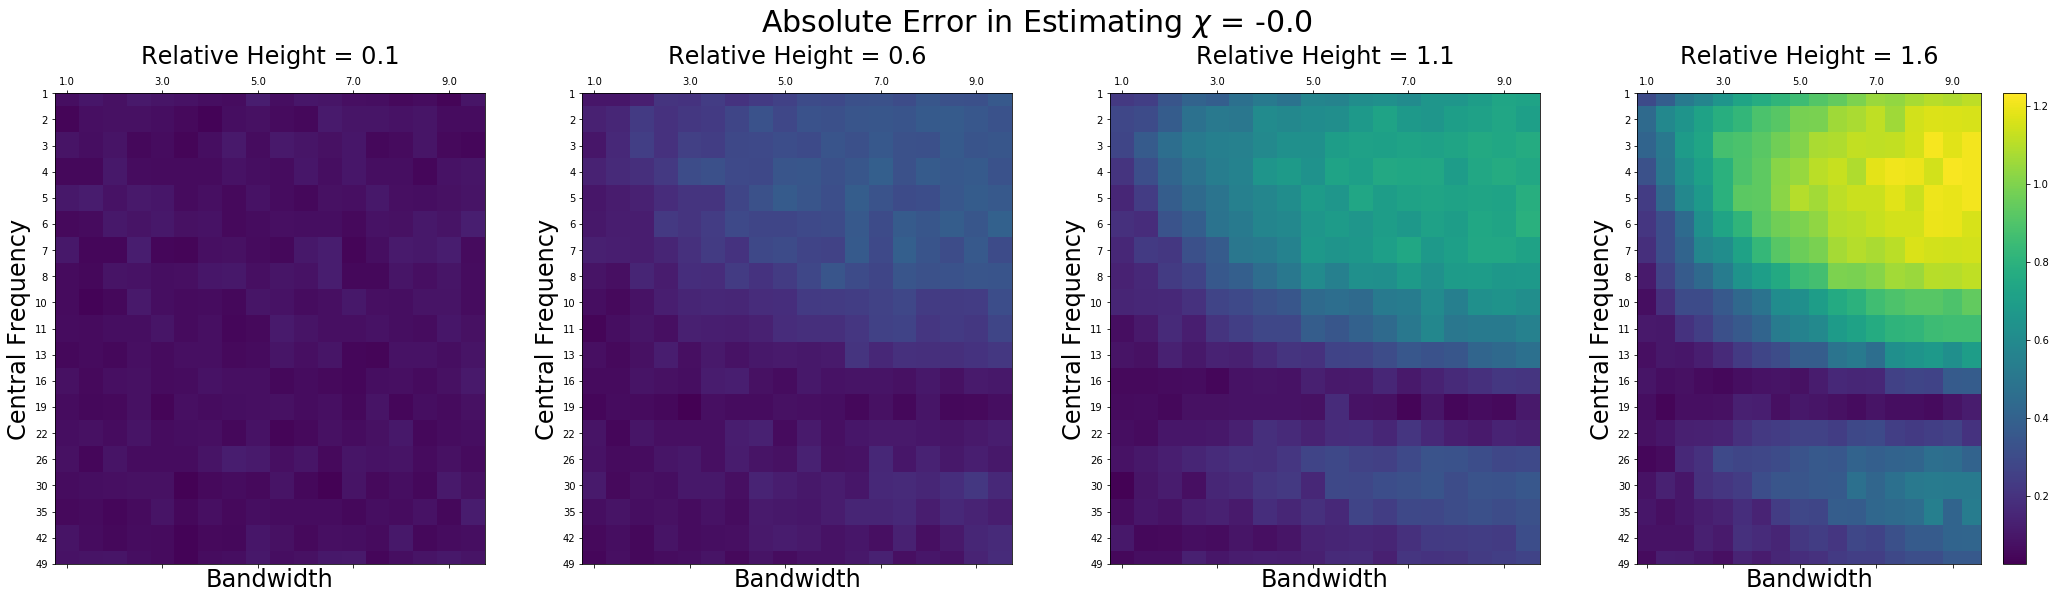

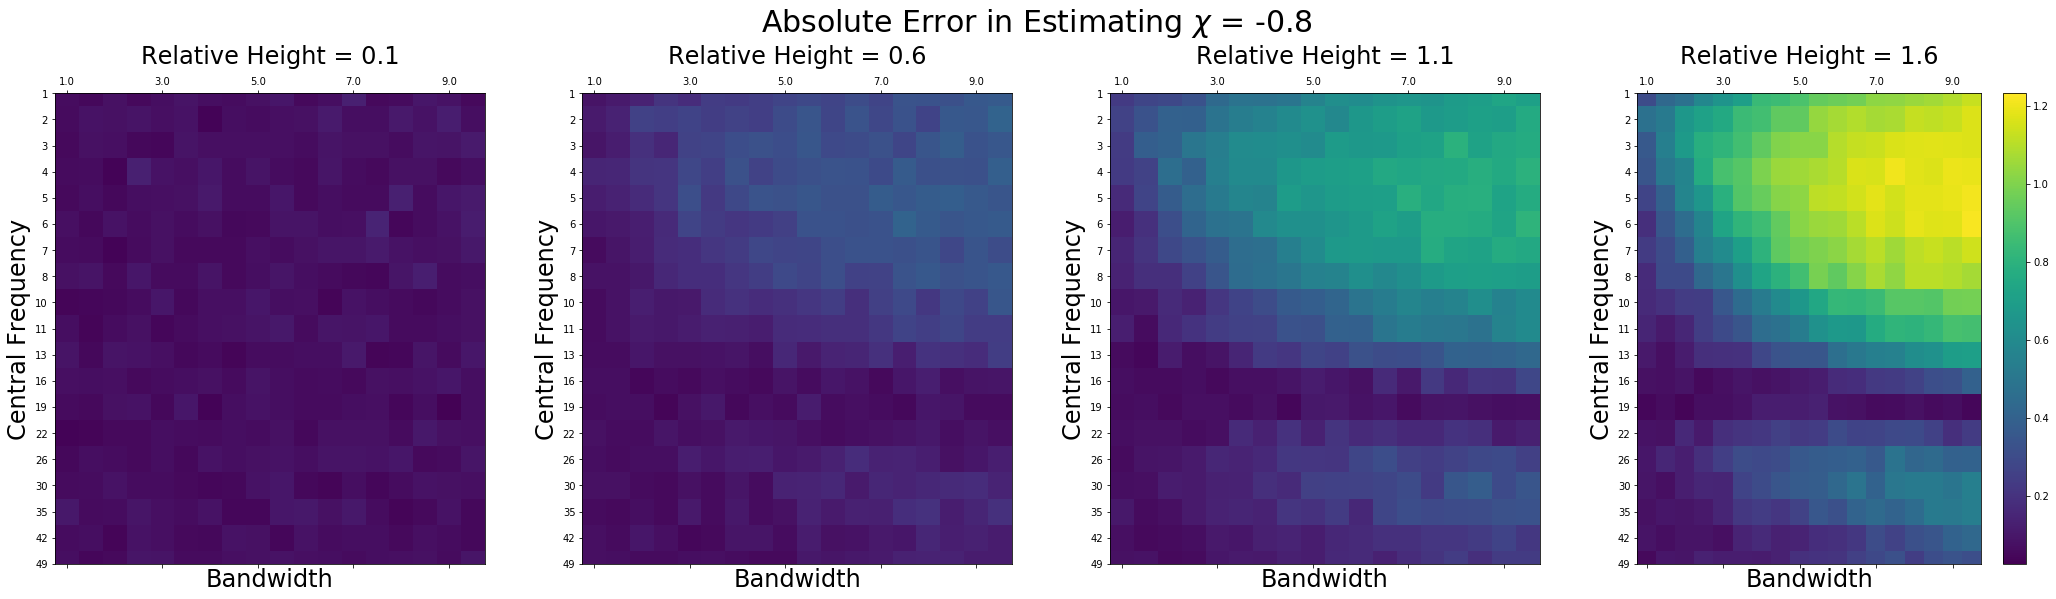

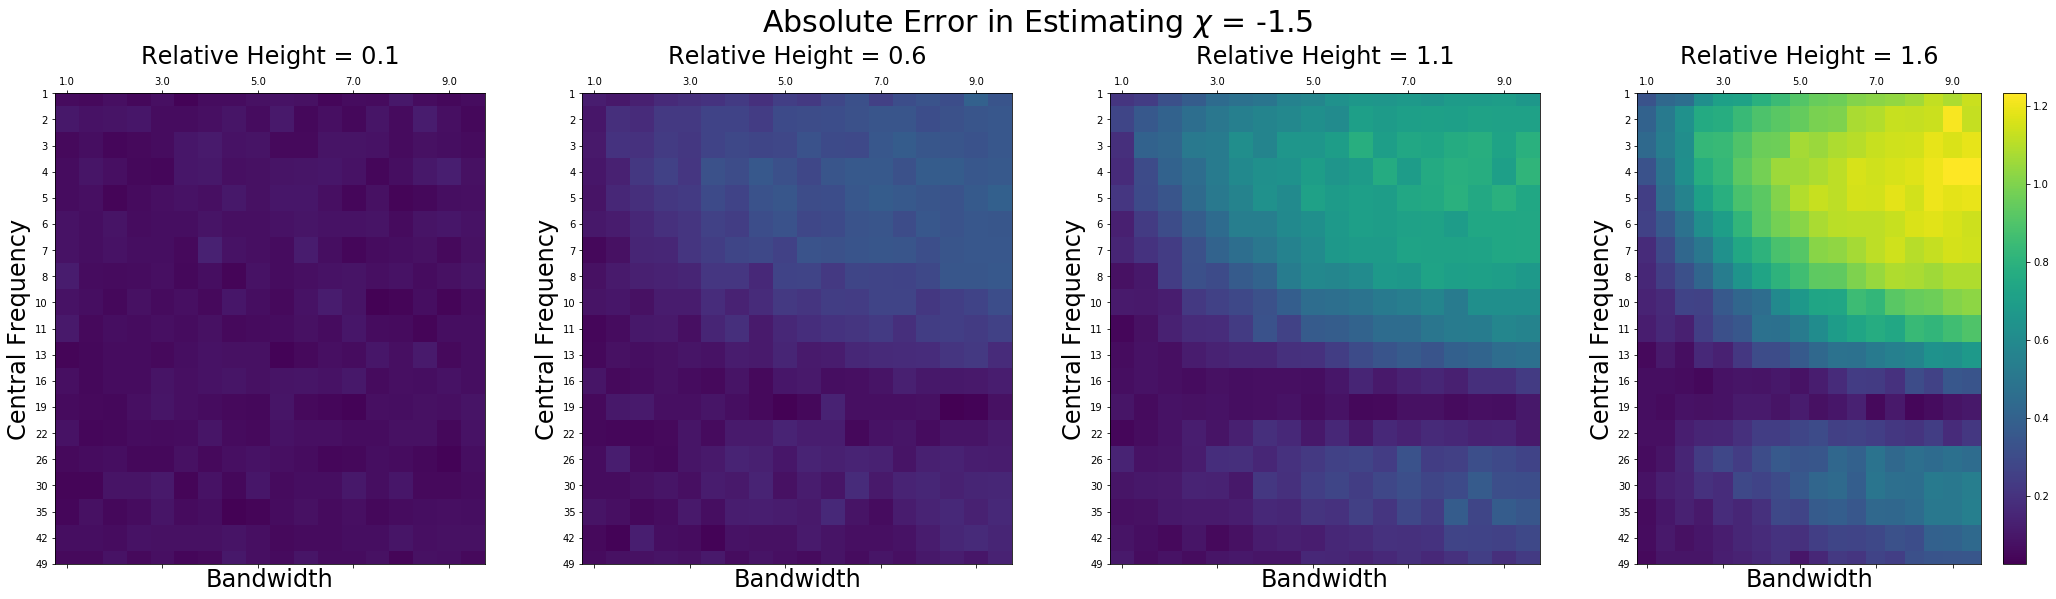

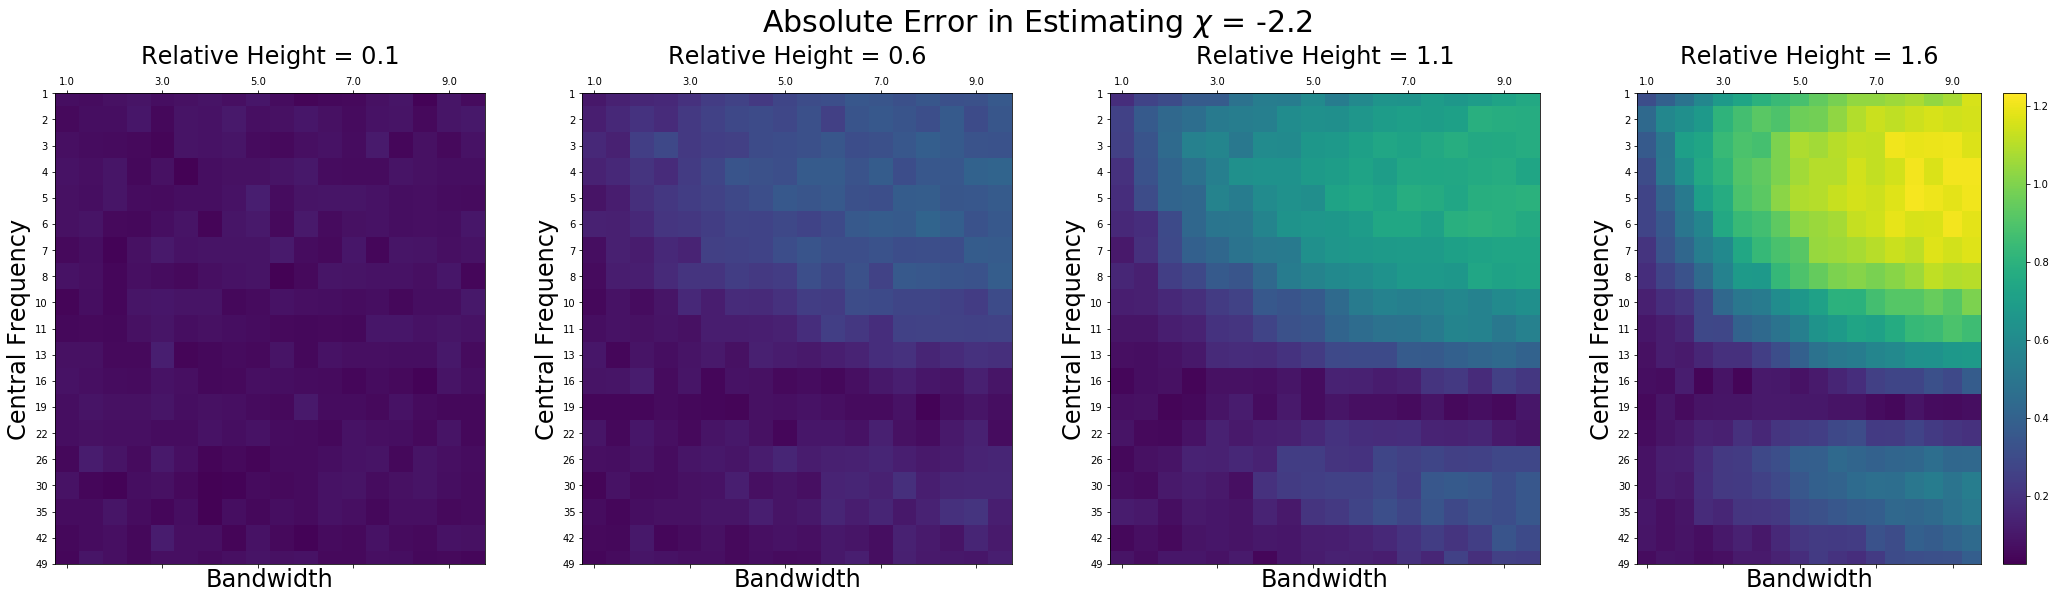

In [219]:
# From an old, outdated experiment.

# rel_heights = HEIGHTS[0:-1:5]
# chis = CHIS[0:-1:3]

# # Grab the dynamic range of the absolute errors for the experiments run with the relative heights and chis
# # that we're looking at
# vmin = df[df.index.get_level_values('relative_height').isin(rel_heights)][[f"{chi}" for chi in chis]].min().min()
# vmax = df[df.index.get_level_values('relative_height').isin(rel_heights)][[f"{chi}" for chi in chis]].max().max()

# for chi in chis:
#     fig, axes = plt.subplots(1,4, figsize = (30,9))
#     for idx, ax in enumerate(axes.ravel()):

#         df_freq_vs_bw = df.iloc[df.index.get_level_values('relative_height') == rel_heights[idx]][f"{chi}"]
#         df_freq_vs_bw = df_freq_vs_bw.droplevel('relative_height').unstack(level=-1)
        
#         cax = ax.matshow(df_freq_vs_bw, aspect='auto', vmin=vmin, vmax=vmax)
#         ax.set_xlabel("Bandwidth", fontsize=24)
#         ax.set_ylabel("Central Frequency", fontsize=24)
#         plt.setp(ax, xticks=[idx for idx in range(0, BANDWIDTHS.shape[0], 4)],
#                 xticklabels=[BANDWIDTHS[idx] for idx in range(0, BANDWIDTHS.shape[0], 4)],
#                 yticks=[idx for idx in range(0, len(FREQS))],
#                 yticklabels=[FREQS[idx] for idx in range(0, len(FREQS))])
#         ax.set_title(rf"Relative Height = {rel_heights[idx]:.1f}", fontsize=24)
#     fig.colorbar(cax)
#     fig.suptitle(rf"Absolute Error in Estimating $\chi$ = {chi:0.1f}", fontsize=30)
#     fig.tight_layout(pad=5.0)
    

## Closer Look

IRASA seems to perform worse at estimating the power law exponent when the relative height and bandwidth of the central frequency are large, particularly for low frequencies. Let's see what's going on pictorially.

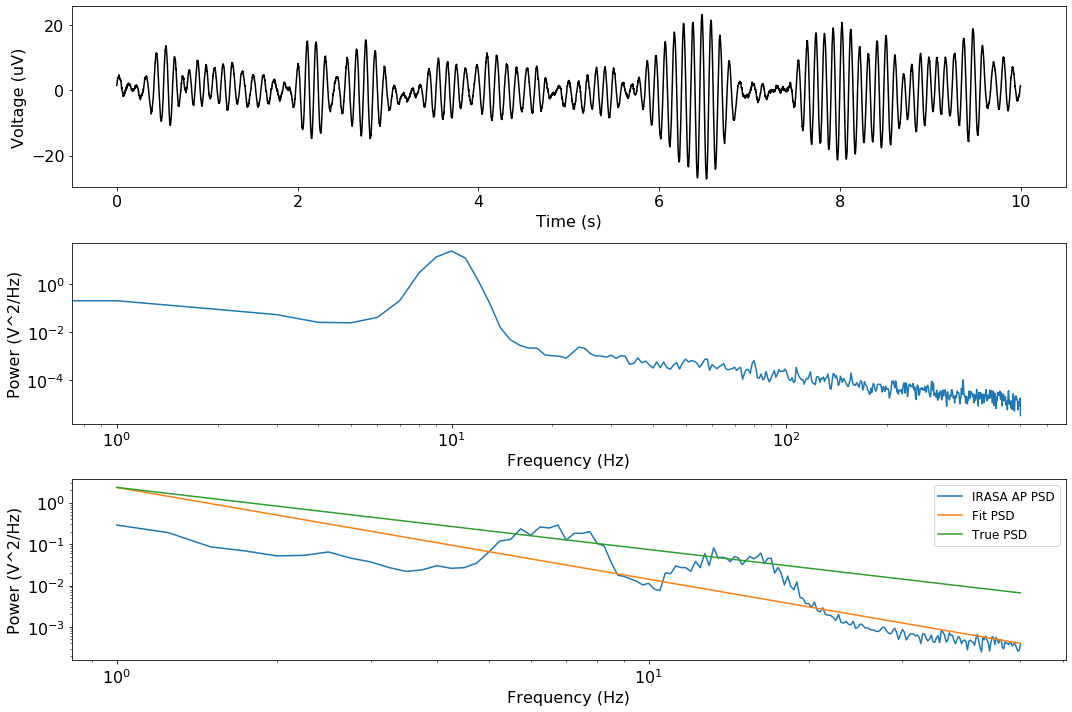

In [99]:
chi = -1.5
central_freq = 10 # In Hz
bandwidth = 2 # In Hz
rel_height = 4 # In 10**Hz

sig = sim_central_freq(N_SECONDS, FS, chi, central_freq, bandwidth, rel_height)
fix, axes = plt.subplots(3,1, figsize=(15, 10))
plot_time_series(times, sig, ax=axes[0])
freqs, psd = compute_spectrum(sig, FS)
plot_power_spectra(freqs, psd, ax=axes[1])

irasa_params = {'fs' : FS, 'f_range' : F_RANGE}
freqs_irasa, psd_ap, psd_pe = compute_irasa(sig, **irasa_params)
fit_offset, fit_chi = fit_irasa(freqs_irasa,psd_ap)

true_psd = freqs_irasa**chi
fit_psd = 10**fit_offset*freqs_irasa**fit_chi 
# Normalize to match intercept with curve fitted irasa PSD
true_psd = fit_psd[0]/true_psd[0] * true_psd
plot_power_spectra(freqs_irasa, [psd_ap, fit_psd, true_psd], labels=["IRASA AP PSD", "Fit PSD", "True PSD"], ax=axes[2])

## Aperiodic Noise with Knee

Now let's take a look at how IRASA behaves on aperiodic noise with no oscillations when the power spectrum follows a knee model. Here, we have three parameters to estimate: the knee, and the two power laws. In the below experiments, we look at estimating only the power law exponents. Further, we only look at those cases in which the exponent of the second half of the knee does not exceed 3.

In [9]:
# Set constants for this particular experiment
# Only choose pairs of chis for which the slope of the second half of the knee is steeper than the first.
# NOTE: The knee simulation uses the convention that chi's are **positive** whereas neurodsp uses negative chis.
# So use positive chi pairs here.
CHI_PAIRS = np.array([(chi1, chi2) for chi1, chi2 in product(-CHIS, -CHIS) if chi1 + chi2 < 3])
KNEES = np.arange(0, 100, 10)
parameter_grid = [(chi1, chi2, knee, trial) for (chi1, chi2), knee, trial in product(CHI_PAIRS, KNEES, range(NUM_TRIALS))]
num_rows = CHI_PAIRS.shape[0]*KNEES.shape[0]*NUM_TRIALS
df = pd.DataFrame(data=np.zeros((num_rows,7)), columns=["chi1", "chi2", "knee", "trial", "err_chi1", "err_chi2", "err_knee"])
df[['chi1', 'chi2', 'knee', 'trial']] = parameter_grid

In [11]:
# Set random seed
np.random.seed(0)

tic = time()
for chi1, chi2, knee, trial_idx in parameter_grid:
    fit_chi1, fit_chi2, fit_knee = knee_trial(N_SECONDS, FS, f_range=F_RANGE, chi1=chi1, chi2=chi2, k=knee)
    loc_mask = (df['chi1'] == chi1) & (df['chi2'] == chi2) & (df['knee'] == knee) & (df['trial'] == trial_idx)
    df.loc[loc_mask, 'err_chi1'] = fit_chi1 - chi1
    df.loc[loc_mask, 'err_chi2'] = fit_chi2 - chi2
    df.loc[loc_mask, 'err_knee'] = fit_knee - knee
toc = time()
print(f"{toc-tic:.2f} seconds")

3139.59 seconds


In [28]:
vmin

-1.2350001538242246

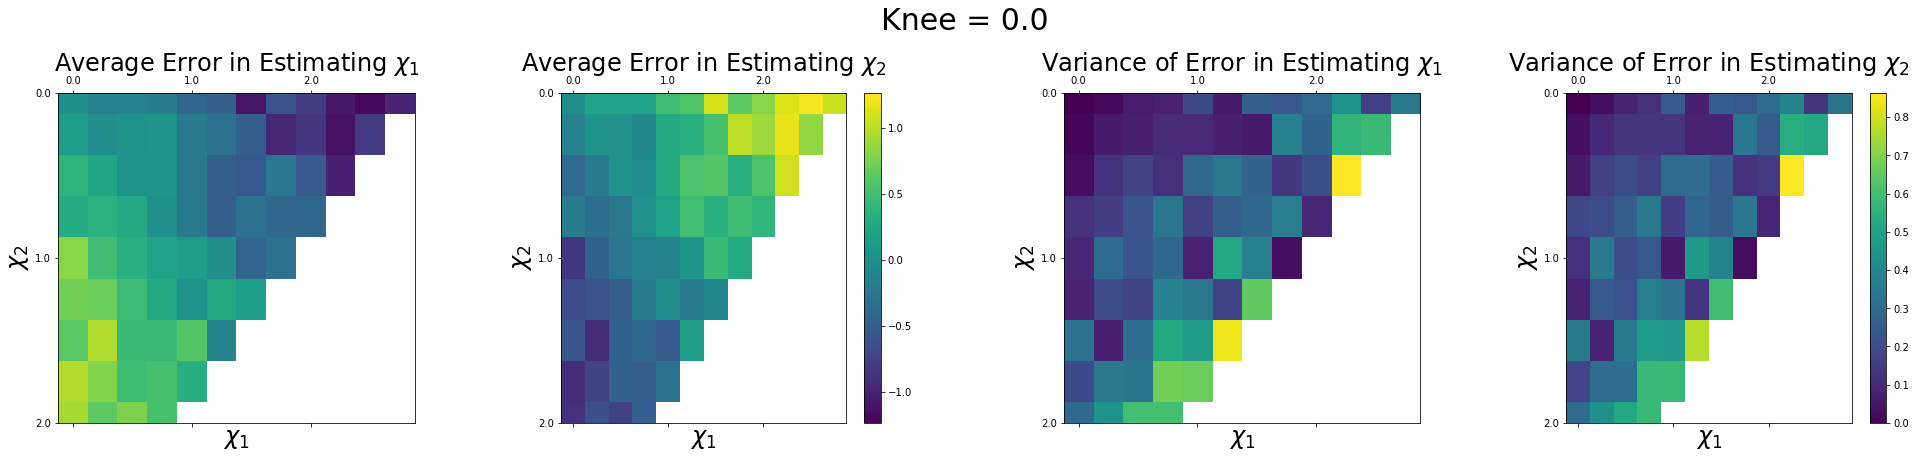

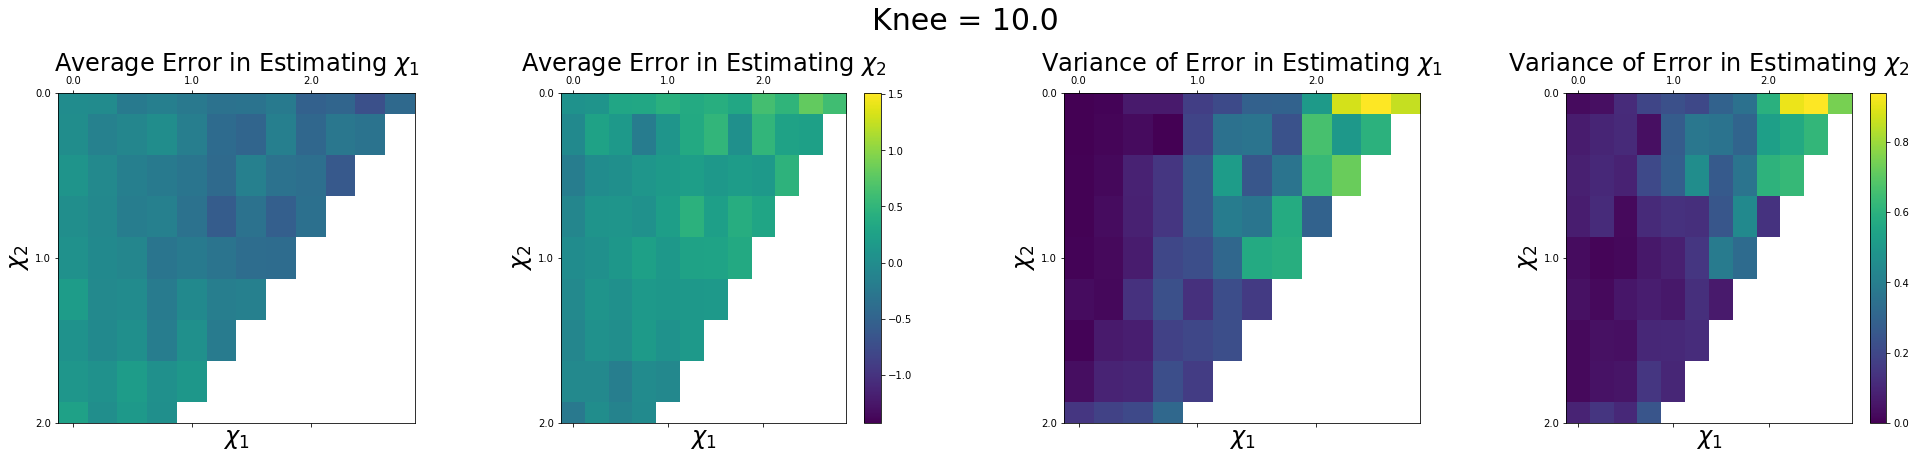

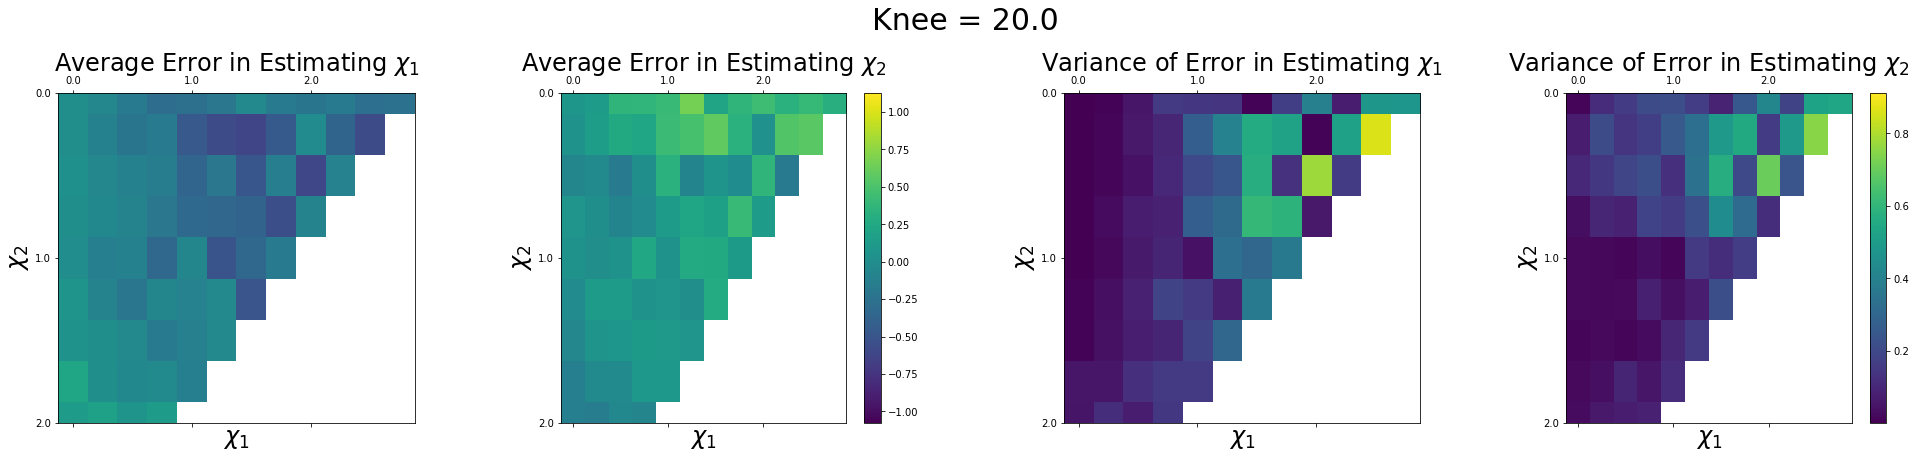

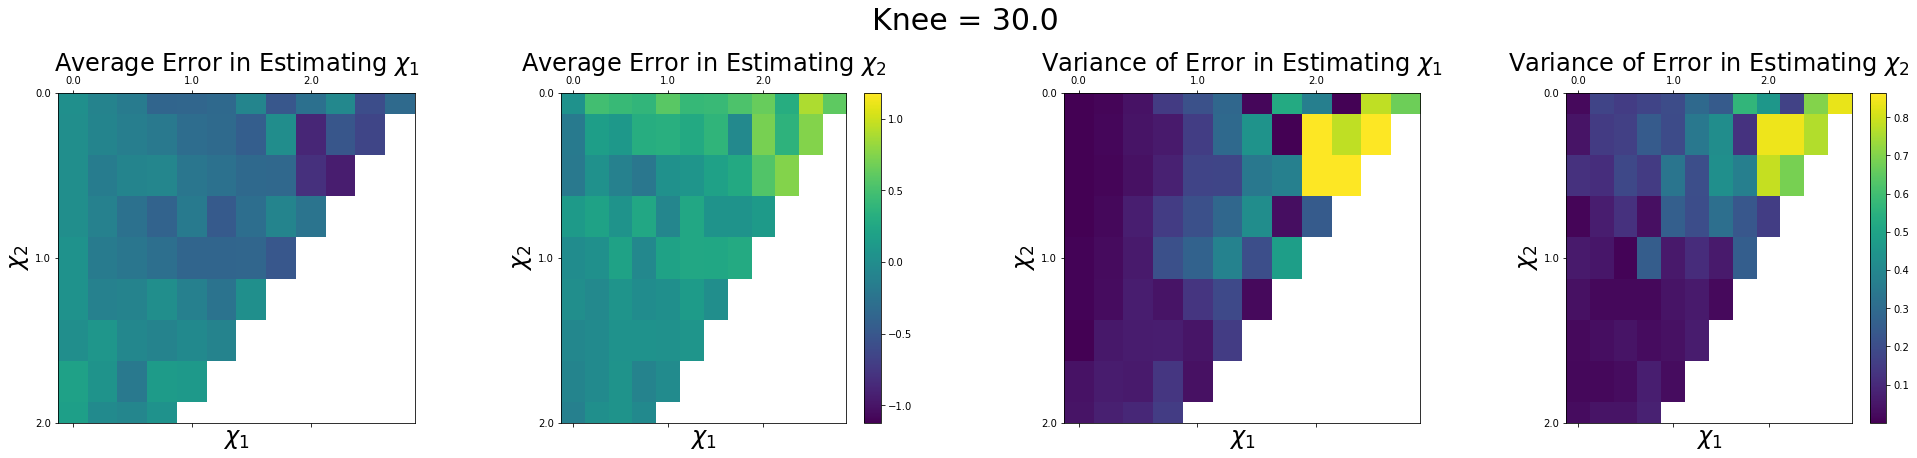

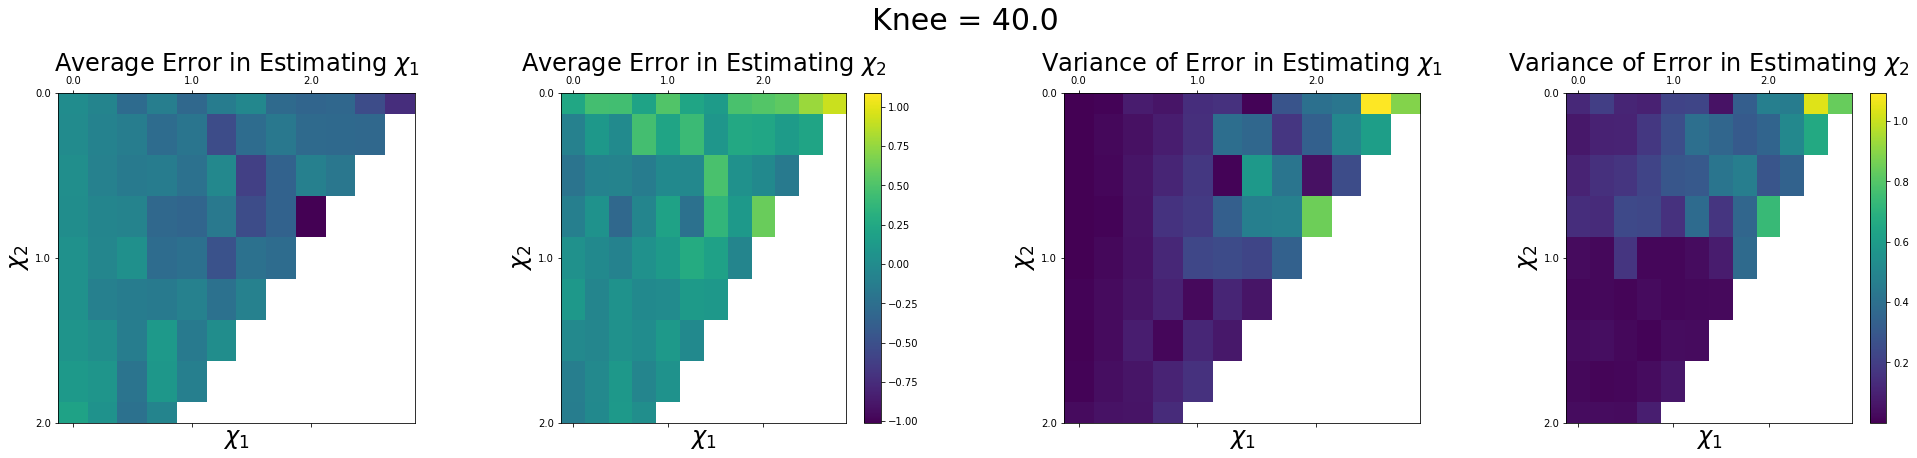

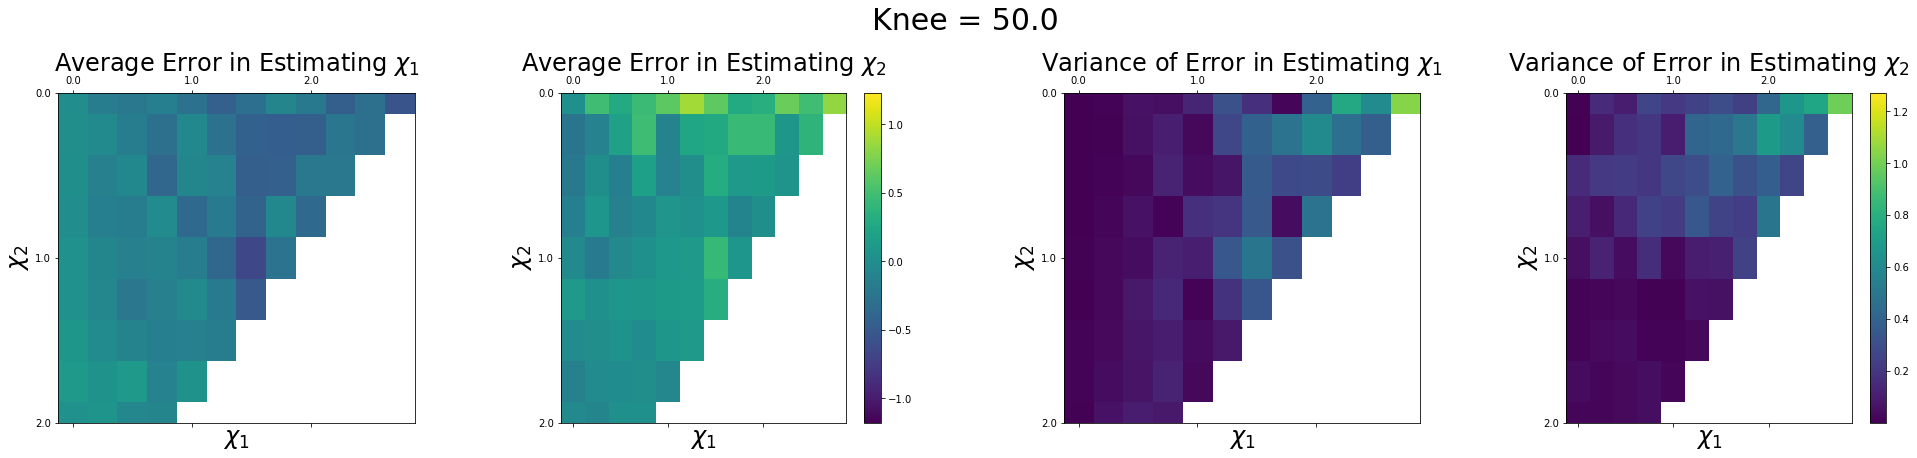

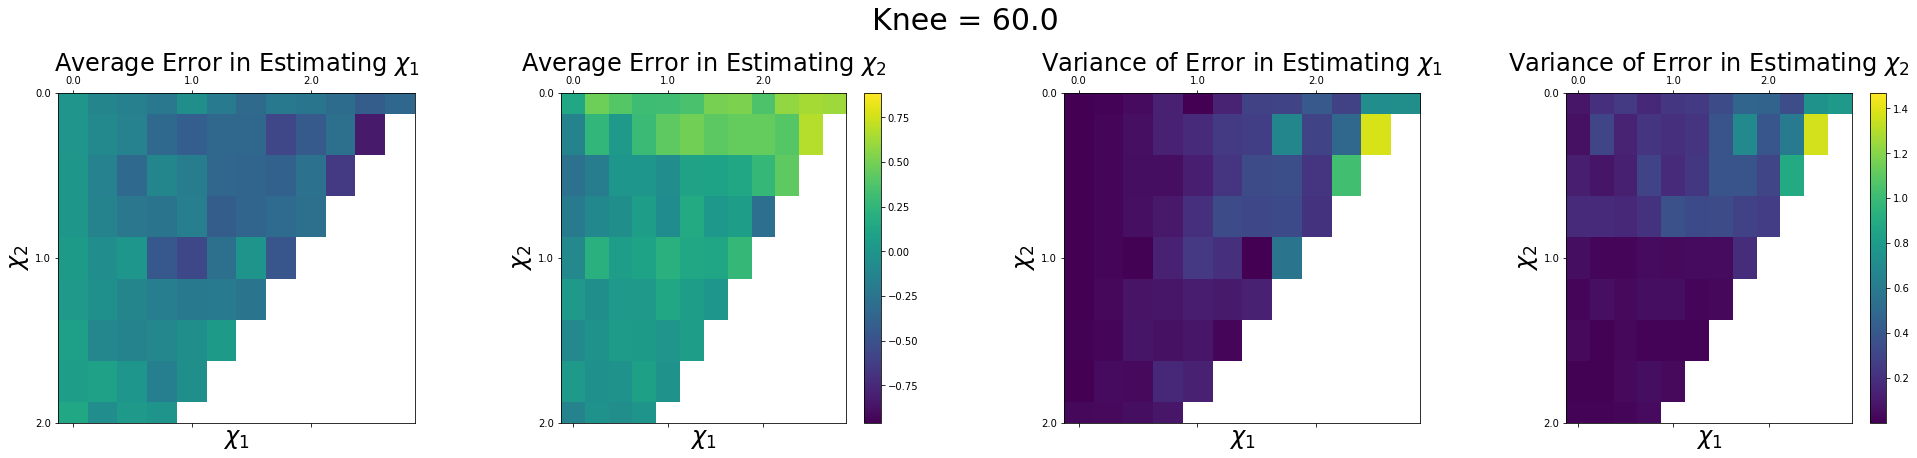

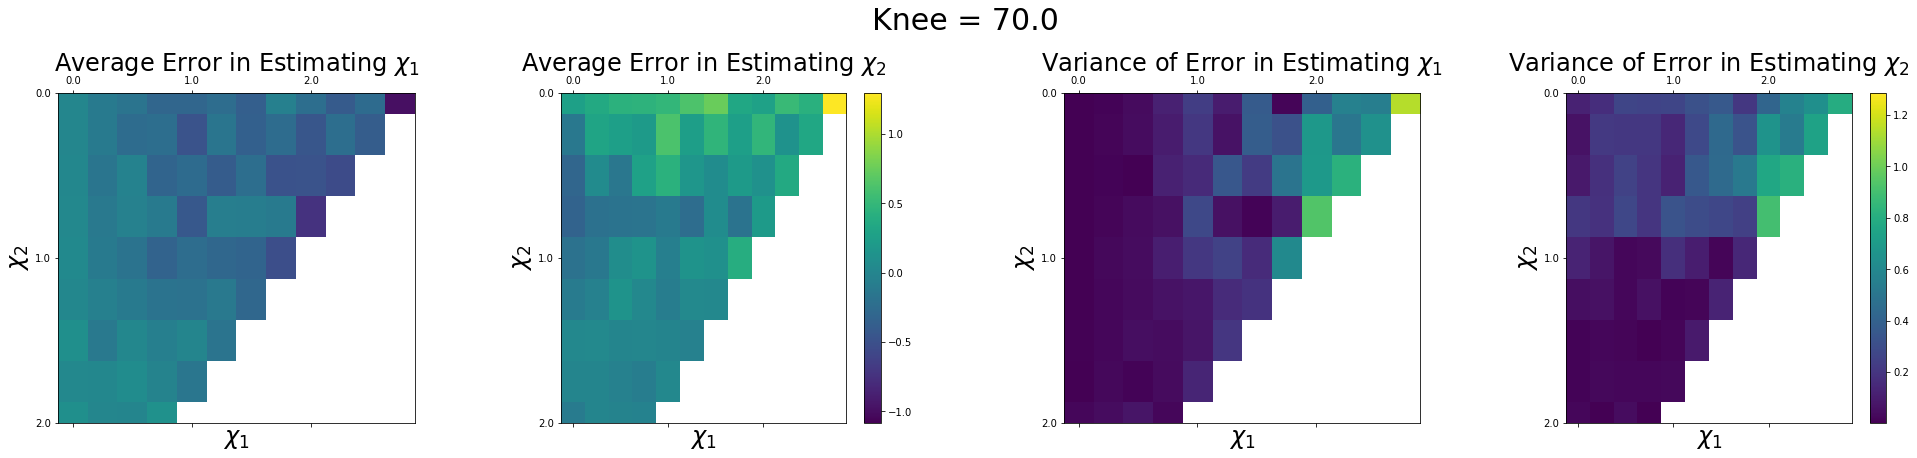

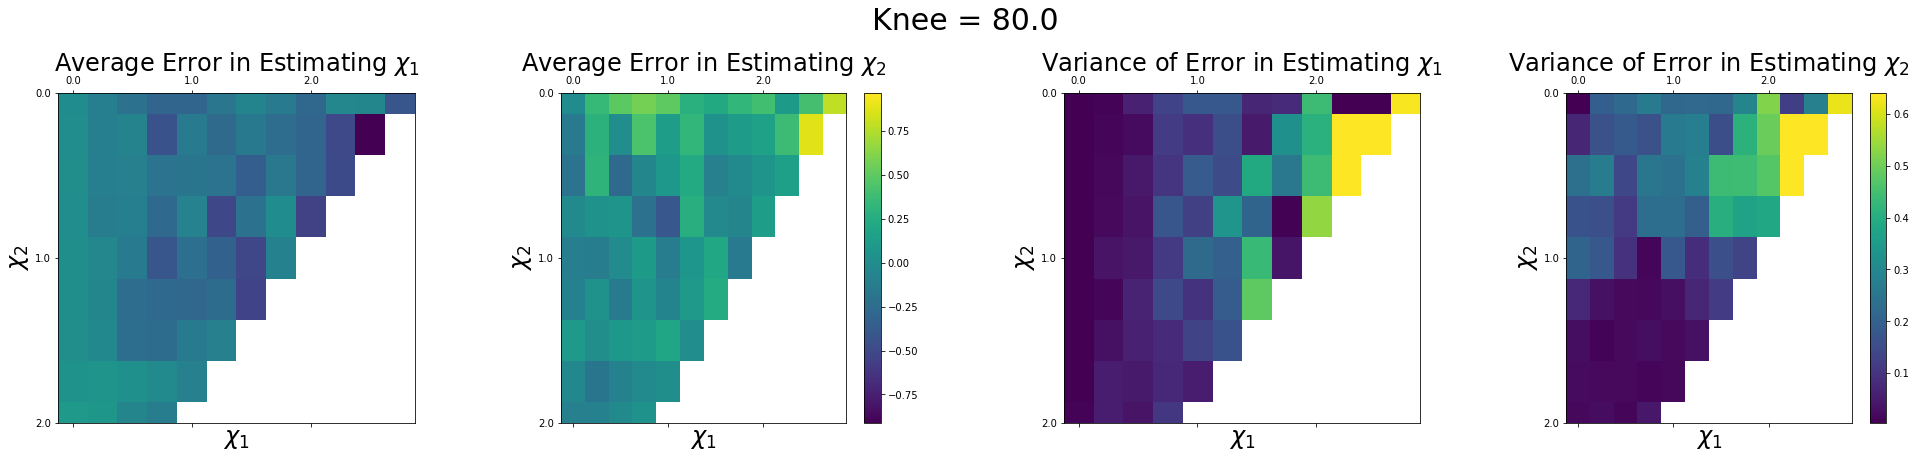

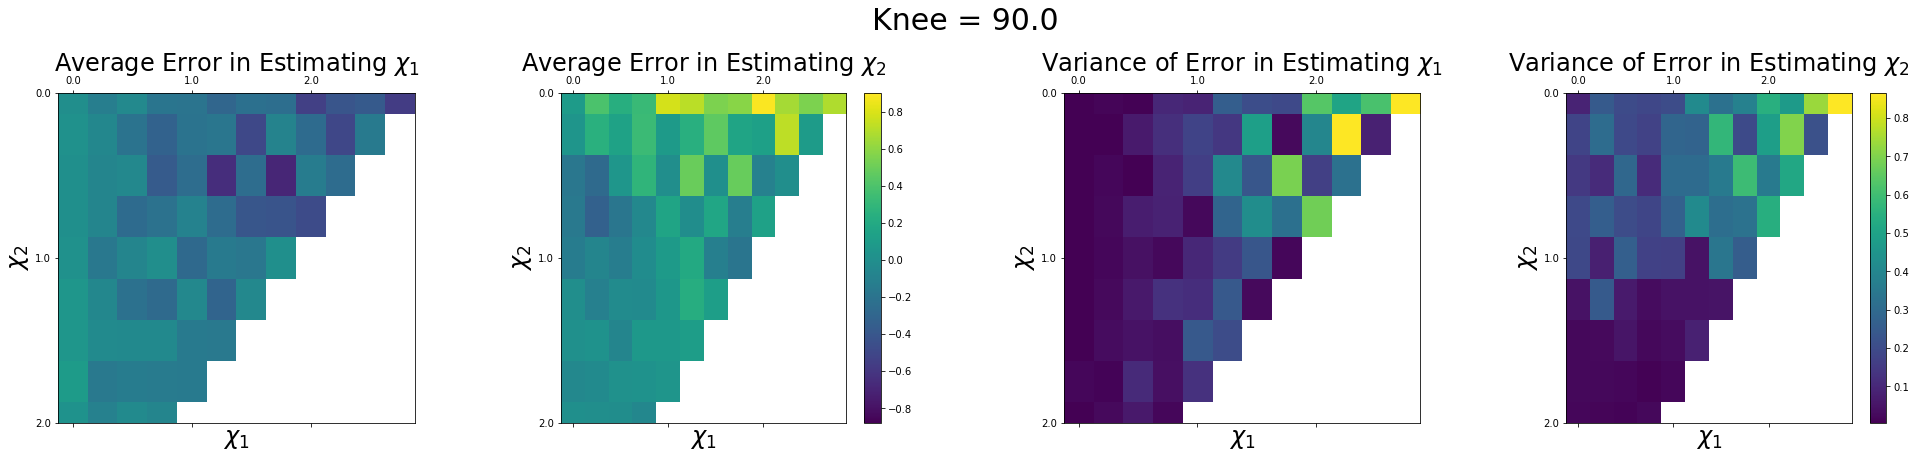

In [30]:
mean_var_df = df.groupby(by=['chi1', 'chi2', 'knee']).agg({'err_chi1': ['mean', 'std'], 'err_chi2': ['mean', 'std'], 'err_knee': ['mean', 'std']})
mean_var_df = pd.DataFrame(mean_var_df.to_records())
mean_var_df.columns = ['chi1', 'chi2', 'knee', 'err_chi1_mean', 'err_chi1_std', 'err_chi2_mean', 'err_chi2_std', 'err_knee_mean', 'err_knee_std']

for knee in KNEES:
    fig, axes = plt.subplots(1,4, figsize = (28,7))
    
    # Grab the dynamic range of the absolute errors so the heatmaps share a colorbar.
    vmin_mean = mean_var_df.loc[df['knee']==knee, ['err_chi1_mean',  'err_chi2_mean']].min().min()
    vmax_mean = mean_var_df.loc[df['knee']==knee, ['err_chi1_mean', 'err_chi2_mean']].max().max()
    
    vmin_var = mean_var_df.loc[df['knee']==knee, ['err_chi1_std',  'err_chi2_std']].min().min()**2
    vmax_var = mean_var_df.loc[df['knee']==knee, ['err_chi1_std', 'err_chi2_std']].max().max()**2
    
    for idx, ax in enumerate(axes.ravel()):
        
        # Grab only the ch1, chi2, and err_chi columns
        if idx == 0:
            ax.set_title(rf"Average Error in Estimating $\chi_1$", fontsize=24)
            # Plot err_chi1_mean heatmap
            chi_mat_errs = mean_var_df.loc[mean_var_df['knee'] == knee, ['chi1', 'chi2', 'err_chi1_mean']]
            # Pivot chi1 column
            chi_mat_errs = chi_mat_errs.set_index(['chi1', 'chi2']).err_chi1_mean.unstack(0)
        elif idx == 1:
            ax.set_title(rf"Average Error in Estimating $\chi_2$", fontsize=24)
            chi_mat_errs = mean_var_df.loc[mean_var_df['knee'] == knee, ['chi1', 'chi2', 'err_chi2_mean']]
            # Pivot chi1 column
            chi_mat_errs = chi_mat_errs.set_index(['chi1', 'chi2']).err_chi2_mean.unstack(0)
        elif idx == 2:
            ax.set_title(rf"Variance of Error in Estimating $\chi_1$", fontsize=24)
            chi_mat_errs = mean_var_df.loc[mean_var_df['knee'] == knee, ['chi1', 'chi2', 'err_chi1_std']]
            # Pivot chi1 column
            chi_mat_errs = chi_mat_errs.set_index(['chi1', 'chi2']).err_chi1_std.unstack(0)**2
        else:
            ax.set_title(rf"Variance of Error in Estimating $\chi_2$", fontsize=24)
            chi_mat_errs = mean_var_df.loc[mean_var_df['knee'] == knee, ['chi1', 'chi2', 'err_chi2_std']]
            # Pivot chi1 column
            chi_mat_errs = chi_mat_errs.set_index(['chi1', 'chi2']).err_chi2_std.unstack(0)**2
        
        # Adjust the range for the colorbar based on whether you're plotting means or variances
        cax = ax.matshow(chi_mat_errs, aspect='auto', vmin=vmin_mean, vmax=vmax_mean) if idx < 2 else ax.matshow(chi_mat_errs, aspect='auto', vmin=vmin_var, vmax=vmax_var)
        ax.set_xlabel(r"$\chi_1$", fontsize=24)
        ax.set_ylabel(r"$\chi_2$", fontsize=24)
        
        ticks = [idx for idx in range(0, CHIS.shape[0], 4)]
        ticklabels = [-CHIS[idx] for idx in range(0, CHIS.shape[0], 4)]
        
        plt.setp(ax, xticks=ticks,
                xticklabels=ticklabels,
                yticks=ticks,
                yticklabels=ticklabels)
        if idx in (1,3): 
            # Add color bar to last mean or variance plot
            fig.colorbar(cax, ax = ax)
    
    fig.suptitle(rf"Knee = {knee:.1f}", fontsize=30)
    fig.tight_layout(pad=5.0)

## Closer Look

It looks like IRASA performs the worst for estimating both $\chi_1$ and $\chi_2$ when the knee is zero. This isn't surprising though, because without the knee the two power law exponents combine to form a simple power law. There are infinitely many choices of the two exponents in this case that would yield the same power spectrum.

Another trend thats apparent in the above heat maps is that IRASA seems to perform worse at estimating both exponents in the regime where \(\chi_2\) is near zero and \(\chi_1\) is near 3.

Let's take a detailed look at one example and compare what the true PSD is to what IRASA estimates it to be.

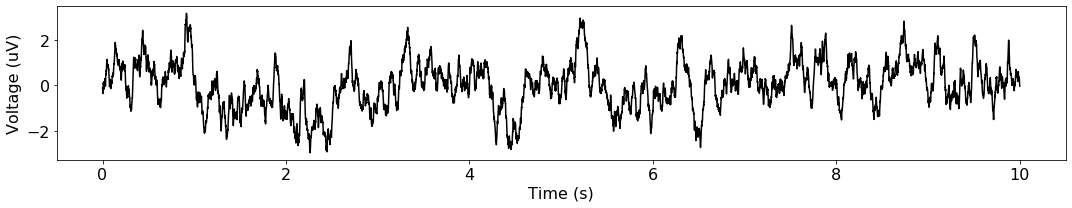

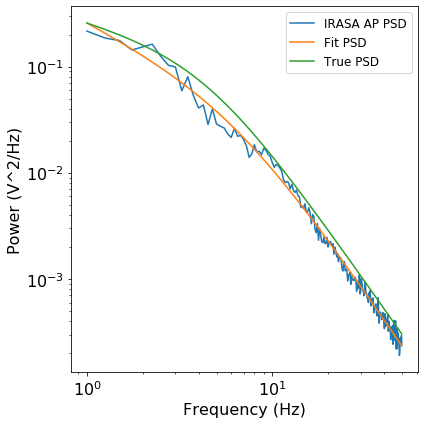

In [97]:
chi1 = 0.5
chi2 = 2
knee = 20.0
times = create_times(N_SECONDS, FS)

sig = sim_knee(N_SECONDS, FS, chi1, chi2, knee)
plot_time_series(times, sig)
freqs, psd = compute_spectrum(sig, FS)

irasa_params = {'fs' : FS, 'f_range' : F_RANGE}
freqs_irasa, psd_ap, psd_pe = compute_irasa(sig, **irasa_params)
fit_offset, fit_chi1, fit_chi2, fit_knee = fit_irasa_knee(freqs_irasa,psd_ap)

true_psd = 1/(freqs_irasa**chi1*(freqs_irasa**chi2 + knee))
fit_psd = fit_offset/(freqs_irasa**fit_chi1 * (freqs_irasa**fit_chi2 + fit_knee))
# Normalize to match intercept with curve fitted irasa PSD
true_psd = fit_psd[0]/true_psd[0] * true_psd
plot_power_spectra(freqs_irasa, [psd_ap, fit_psd, true_psd], labels=["IRASA AP PSD", "Fit PSD", "True PSD"])